# TESS Atlas fit for TOI 502

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 502.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-502.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-502.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-502.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 502

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 502 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

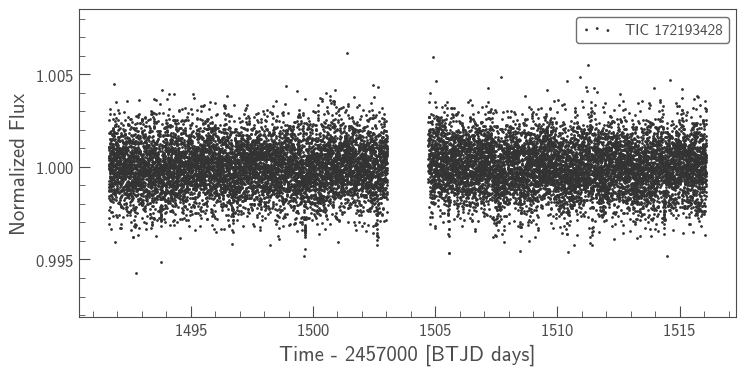

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -34269.77048250546 -> -34229.16630917746


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -28587.783493882216 -> -27455.47794388606


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -27455.47794388606 -> -26971.83412201784


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -26971.83412201784 -> -26971.833734814998


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -26971.833734814998 -> -26971.670865726977


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -26971.670865726977 -> -26971.66957314088


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -26971.66957314088 -> -26969.068746020985


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -26969.06874602098 -> -26969.068746020817


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -26969.06874602082 -> -26969.068746020723


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -26969.068746020723 -> -26969.068746020723


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -26969.068746020723 -> -26969.068746020723


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -26969.068746020723 -> -26969.068746020723


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -26969.068746020723 -> -26969.068746020723


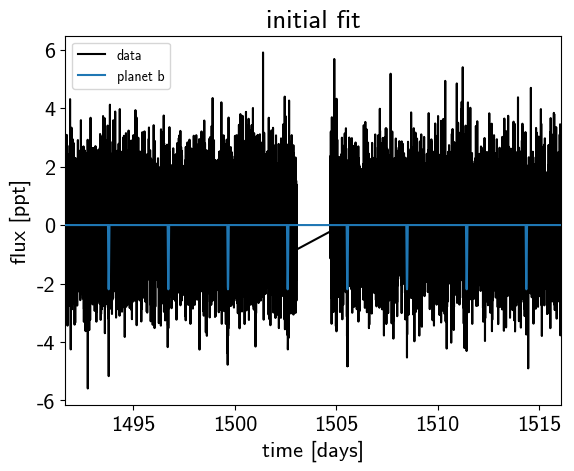

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:06, 13.72draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:08, 11.38draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:18,  5.02draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:21,  4.38draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:22,  4.00draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:26,  3.35draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:22,  3.92draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:30,  2.93draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:27,  3.07draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:22,  3.77draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:27,  3.07draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:24,  3.36draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:25,  3.16draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:25,  3.16draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:25,  3.12draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:26,  2.98draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:22,  3.42draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:26,  2.86draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:24,  3.03draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:19,  3.74draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:23,  3.07draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:20,  3.56draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:08<00:25,  2.76draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:20,  3.50draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:23,  2.91draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:09<00:20,  3.38draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:23,  2.83draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:09<00:19,  3.30draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:10<00:21,  3.00draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:10<00:19,  3.23draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:10<00:20,  3.02draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:11<00:20,  3.09draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:11<00:18,  3.31draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:11<00:20,  2.98draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:16,  3.60draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:12<00:21,  2.73draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:13<00:19,  2.92draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:13<00:17,  3.10draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:13<00:14,  3.57draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:14<00:16,  3.19draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:14<00:15,  3.37draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:14<00:14,  3.43draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:15<00:15,  3.23draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:15<00:13,  3.54draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:15<00:15,  3.07draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:15<00:12,  3.74draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:16<00:15,  2.91draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:17<00:14,  2.93draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:17<00:13,  3.11draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:17<00:12,  3.32draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:18<00:11,  3.38draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:18<00:12,  2.96draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:18<00:10,  3.40draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:19<00:13,  2.70draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:19<00:12,  2.76draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:20<00:10,  2.92draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:20<00:08,  3.57draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:21<00:09,  3.12draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:21<00:09,  3.16draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:21<00:08,  3.28draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:22<00:09,  2.89draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:22<00:07,  3.66draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:22<00:08,  2.80draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:23<00:07,  3.00draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:23<00:06,  3.63draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:23<00:06,  3.15draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:24<00:06,  3.20draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:24<00:05,  3.28draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:24<00:06,  2.97draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:25<00:04,  3.57draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:25<00:05,  2.71draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:26<00:04,  2.86draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:26<00:03,  3.02draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:26<00:03,  3.46draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:27<00:03,  2.78draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:27<00:02,  3.30draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:28<00:03,  2.21draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:29<00:03,  1.86draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:29<00:03,  1.68draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:30<00:02,  1.70draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:30<00:01,  2.12draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:31<00:01,  1.86draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:32<00:01,  1.72draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:32<00:00,  1.67draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:35<00:00,  1.21s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:06, 14.38draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:08, 11.37draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:18,  4.96draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:17,  5.13draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:22,  3.97draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:24,  3.61draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:22,  3.95draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:29,  3.02draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:24,  3.55draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:30,  2.81draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:23,  3.56draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:30,  2.73draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:26,  3.10draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:25,  3.10draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:22,  3.50draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:23,  3.31draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:24,  3.13draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:24,  3.10draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:28,  2.59draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:22,  3.28draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:29,  2.41draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:08<00:26,  2.70draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:21,  3.14draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:09<00:26,  2.56draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:20,  3.19draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:10<00:27,  2.39draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:10<00:21,  3.04draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:10<00:27,  2.31draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:11<00:24,  2.51draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:11<00:18,  3.23draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:12<00:19,  3.09draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:12<00:24,  2.40draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:12<00:18,  3.04draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:13<00:23,  2.43draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:13<00:17,  3.05draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:13<00:16,  3.17draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:14<00:20,  2.49draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:15<00:18,  2.63draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:15<00:16,  2.87draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:16<00:12,  3.61draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:16<00:12,  3.48draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:16<00:14,  3.00draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:16<00:12,  3.57draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:17<00:14,  2.92draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:18<00:13,  2.98draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:18<00:12,  3.13draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:18<00:10,  3.55draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:19<00:11,  3.24draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:19<00:09,  3.59draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:19<00:07,  4.14draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:20<00:10,  2.92draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:20<00:09,  3.16draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:20<00:09,  3.18draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:21<00:12,  2.33draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:22<00:10,  2.47draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:22<00:09,  2.75draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:22<00:08,  2.88draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:23<00:08,  2.67draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:23<00:06,  3.31draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:24<00:08,  2.49draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:24<00:06,  3.11draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:24<00:07,  2.70draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:25<00:07,  2.40draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:25<00:06,  2.61draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:26<00:06,  2.60draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:26<00:04,  3.11draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:27<00:05,  2.35draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:28<00:07,  1.67draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:28<00:08,  1.49draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:29<00:04,  2.05draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:29<00:05,  1.57draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:30<00:05,  1.56draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:31<00:04,  1.55draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:31<00:03,  1.88draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:32<00:02,  1.77draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:32<00:02,  1.69draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:33<00:01,  1.57draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:34<00:01,  1.56draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:34<00:00,  1.51draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:37<00:00,  1.27s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:36,  2.10draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<01:27,  2.31draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:00<01:05,  3.04draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:29,  2.23draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:14,  2.63draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:02<00:58,  3.36draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:02<00:51,  3.76draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:02<01:01,  3.18draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:03<01:05,  2.96draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:03<01:04,  2.97draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:04<01:11,  2.66draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:04<00:55,  3.40draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:04<00:53,  3.54draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:04<00:56,  3.34draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:05<00:44,  4.15draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:05<00:58,  3.13draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:05<00:54,  3.38draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:06<00:52,  3.46draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:06<00:48,  3.70draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:06<00:39,  4.50draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:06<00:47,  3.78draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:07<00:47,  3.73draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:07<00:56,  3.13draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:07<00:48,  3.63draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:07<00:47,  3.68draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:08<00:38,  4.51draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:08<00:38,  4.43draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:08<00:41,  4.15draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:09<00:44,  3.82draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:09<00:41,  4.08draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:09<00:37,  4.46draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:10<00:43,  3.77draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:10<00:42,  3.90draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:11<00:52,  3.08draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:11<00:49,  3.30draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:11<00:59,  2.71draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:12<00:51,  3.10draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:12<00:43,  3.69draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:12<00:40,  3.88draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:12<00:40,  3.85draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:12<00:39,  3.94draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:13<00:35,  4.37draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:13<00:43,  3.54draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:13<00:34,  4.34draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:14<00:50,  3.02draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:14<00:41,  3.59draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:15<00:49,  3.00draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:15<00:44,  3.31draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:15<00:43,  3.34draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:15<00:37,  3.82draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:15<00:33,  4.31draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:16<00:30,  4.65draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:16<00:34,  4.04draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:16<00:36,  3.81draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:17<00:30,  4.46draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:17<00:25,  5.35draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:17<00:30,  4.53draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:17<00:28,  4.80draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:18<00:32,  4.07draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:18<00:44,  2.98draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:18<00:32,  4.04draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:18<00:28,  4.49draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:19<00:25,  4.97draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:19<00:28,  4.43draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:19<00:28,  4.42draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:20<00:29,  4.18draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:20<00:27,  4.44draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:21<00:31,  3.84draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:21<00:24,  4.78draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:21<00:38,  3.10draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:21<00:28,  4.02draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:22<00:23,  4.93draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:22<00:19,  5.71draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:22<00:21,  5.27draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:22<00:20,  5.46draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:23<00:33,  3.25draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:23<00:28,  3.69draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:24<00:36,  2.89draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:24<00:30,  3.48draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:24<00:31,  3.32draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:25<00:34,  2.98draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:25<00:31,  3.22draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:25<00:27,  3.63draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:25<00:26,  3.77draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:26<00:23,  4.16draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:26<00:20,  4.85draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:26<00:24,  3.97draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:27<00:26,  3.59draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:27<00:22,  4.22draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:28<00:20,  4.46draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:28<00:24,  3.73draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:28<00:21,  4.09draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:29<00:23,  3.74draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:29<00:27,  3.11draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:29<00:26,  3.16draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:30<00:22,  3.66draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:30<00:33,  2.47draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:31<00:28,  2.86draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:31<00:30,  2.67draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:31<00:27,  2.87draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:32<00:27,  2.82draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:32<00:26,  2.89draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:32<00:22,  3.33draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:33<00:22,  3.32draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:33<00:24,  2.97draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:34<00:26,  2.79draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:34<00:22,  3.18draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:34<00:26,  2.60draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:35<00:22,  3.06draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:35<00:24,  2.73draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:35<00:21,  3.16draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:36<00:23,  2.79draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:36<00:22,  2.87draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:36<00:18,  3.45draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:37<00:21,  2.94draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:37<00:19,  3.13draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:38<00:17,  3.32draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:38<00:14,  3.85draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:39<00:16,  3.27draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:39<00:14,  3.75draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:39<00:15,  3.39draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:40<00:17,  3.03draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:40<00:14,  3.48draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:40<00:13,  3.77draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:41<00:16,  2.89draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:41<00:15,  3.08draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:41<00:12,  3.80draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:41<00:13,  3.36draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:42<00:12,  3.50draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:42<00:16,  2.67draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:42<00:11,  3.55draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:43<00:15,  2.68draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:43<00:12,  3.22draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:44<00:13,  2.91draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:44<00:14,  2.62draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:44<00:11,  3.11draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:44<00:09,  3.87draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:45<00:12,  2.83draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:45<00:11,  2.87draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:46<00:09,  3.26draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:46<00:08,  3.59draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:46<00:08,  3.72draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:46<00:06,  4.40draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:47<00:10,  2.79draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:47<00:07,  3.54draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:47<00:06,  3.75draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:48<00:05,  3.91draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:48<00:05,  3.97draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:48<00:04,  4.23draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:48<00:04,  4.56draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:48<00:03,  5.62draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:49<00:02,  5.88draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:49<00:02,  6.38draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:49<00:01,  7.05draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:50<00:03,  3.69draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:50<00:02,  4.48draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:50<00:01,  5.78draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:50<00:01,  5.23draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:51<00:01,  4.26draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:51<00:01,  3.83draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:52<00:00,  2.98draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:53<00:00,  2.55draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:53<00:00,  3.82draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:15, 26.31draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:19, 20.56draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:37, 10.63draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:32, 11.94draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:01<00:38, 10.16draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:01<00:40,  9.75draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:01<00:46,  8.37draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:01<00:38, 10.02draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:01<00:32, 11.68draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:01<00:34, 10.94draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:02<00:48,  7.78draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:02<00:50,  7.55draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:02<00:44,  8.46draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:02<00:41,  9.08draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:03<00:34, 10.63draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:03<00:39,  9.42draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:03<00:33, 11.10draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:03<00:37,  9.74draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:04<00:36, 10.00draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:04<00:35, 10.29draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:04<00:31, 11.22draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:04<00:28, 12.50draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:04<00:28, 12.55draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:04<00:30, 11.60draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:05<00:30, 11.30draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:05<00:25, 13.76draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:05<00:32, 10.62draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:05<00:29, 11.55draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:05<00:27, 12.54draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:05<00:28, 11.85draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:06<00:41,  8.16draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:06<00:48,  6.85draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:06<00:51,  6.55draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:07<00:43,  7.57draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:07<00:39,  8.35draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:07<00:32, 10.16draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:07<00:28, 11.37draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:07<00:23, 13.77draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:07<00:22, 14.01draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:08<00:27, 11.67draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:08<00:25, 12.38draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:08<00:24, 12.74draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:08<00:29, 10.67draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:08<00:25, 12.10draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:09<00:30,  9.92draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:09<00:24, 12.14draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:09<00:23, 12.62draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:09<00:21, 14.08draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:09<00:20, 14.49draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:09<00:19, 14.92draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:10<00:21, 13.65draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:10<00:19, 14.50draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:10<00:17, 15.92draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:10<00:20, 14.02draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:10<00:18, 15.40draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:10<00:20, 13.61draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:11<00:20, 13.33draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:11<00:18, 14.93draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:11<00:16, 16.26draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:11<00:17, 15.54draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:11<00:15, 17.10draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:11<00:14, 18.37draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:11<00:14, 18.22draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:12<00:17, 15.09draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:12<00:18, 14.18draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:12<00:16, 15.40draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:12<00:17, 14.28draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:12<00:16, 15.30draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:12<00:15, 16.09draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:13<00:20, 11.67draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:13<00:20, 11.78draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:13<00:22, 10.69draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:13<00:21, 11.03draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:13<00:20, 11.38draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:13<00:19, 11.94draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:14<00:18, 12.49draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:14<00:16, 13.67draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:14<00:13, 16.22draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:14<00:13, 16.68draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:14<00:12, 17.51draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:14<00:15, 14.69draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:14<00:14, 15.00draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:15<00:16, 13.34draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:15<00:14, 14.46draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:15<00:15, 13.46draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:15<00:15, 13.23draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:15<00:15, 13.14draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:15<00:15, 12.92draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:16<00:13, 14.81draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:16<00:12, 15.71draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:16<00:11, 17.04draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:16<00:10, 18.85draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:16<00:10, 17.86draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:16<00:09, 19.73draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:17<00:10, 16.88draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:17<00:14, 12.87draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:17<00:13, 13.42draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:17<00:15, 11.26draws/s]

Sampling 2 chains:  56%|█████▋    | 228/404 [00:17<00:14, 11.82draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:17<00:13, 12.61draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:18<00:12, 14.10draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:18<00:13, 12.94draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:18<00:10, 15.29draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:18<00:11, 14.67draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:18<00:09, 16.89draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:18<00:10, 14.57draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [00:19<00:11, 13.62draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:19<00:12, 12.38draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:19<00:11, 13.48draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:19<00:11, 13.41draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:19<00:11, 13.23draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [00:19<00:09, 15.24draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [00:19<00:08, 17.08draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:20<00:07, 18.16draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:20<00:07, 17.75draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:20<00:07, 17.24draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:20<00:07, 17.18draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:20<00:06, 18.29draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:20<00:06, 18.75draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:21<00:06, 19.58draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:21<00:06, 19.32draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:21<00:06, 19.09draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:21<00:06, 18.10draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:21<00:05, 18.92draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:21<00:05, 18.90draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [00:21<00:06, 16.55draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:21<00:06, 17.43draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:22<00:06, 15.60draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:22<00:05, 17.12draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:22<00:06, 16.29draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:22<00:05, 17.32draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:22<00:05, 17.08draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:22<00:05, 17.36draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:22<00:04, 18.21draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:22<00:04, 18.63draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:23<00:04, 17.36draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:23<00:05, 15.62draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:23<00:04, 16.61draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:23<00:04, 16.88draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:23<00:04, 16.36draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [00:23<00:04, 15.10draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:24<00:05, 12.44draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:24<00:05, 13.04draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [00:24<00:05, 12.17draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:24<00:04, 14.60draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:24<00:03, 15.26draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:24<00:03, 14.74draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:25<00:03, 14.15draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:25<00:03, 14.39draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:25<00:03, 14.73draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:25<00:02, 17.29draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [00:25<00:02, 19.70draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:25<00:02, 19.51draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:25<00:02, 18.47draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:26<00:01, 20.07draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:26<00:01, 18.33draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:26<00:01, 18.75draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:26<00:01, 17.54draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:26<00:01, 16.79draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:26<00:01, 14.11draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:27<00:01, 13.36draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:27<00:01, 14.08draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [00:27<00:01, 12.36draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:27<00:01, 10.79draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:27<00:01,  9.91draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [00:28<00:01,  8.36draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:28<00:01,  7.72draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:28<00:01,  7.12draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:28<00:01,  7.05draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:28<00:00,  7.97draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:29<00:00,  9.28draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:29<00:00,  9.82draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:29<00:00, 10.23draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:35, 22.47draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<00:34, 23.24draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:41, 19.07draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<00:50, 15.72draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:00<00:53, 14.77draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:00<00:55, 14.14draws/s]

Sampling 2 chains:   2%|▏         | 18/804 [00:01<00:45, 17.12draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:01<00:58, 13.47draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:01<01:07, 11.59draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:01<01:02, 12.45draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:02<01:57,  6.64draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:02<02:10,  5.95draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:02<01:47,  7.21draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:02<01:39,  7.78draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:03<01:31,  8.45draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:03<01:23,  9.22draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:03<01:22,  9.23draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:03<01:12, 10.58draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:03<01:15, 10.13draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:04<01:24,  9.02draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:04<01:10, 10.74draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:04<01:08, 11.00draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:04<01:08, 10.93draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:04<01:21,  9.26draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:05<01:08, 10.92draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:05<01:02, 11.91draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:05<01:02, 12.00draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:05<00:56, 13.19draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:05<01:00, 12.29draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:05<01:02, 11.78draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:06<00:55, 13.35draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:06<00:49, 14.81draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:06<01:32,  7.93draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:07<01:48,  6.73draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:07<01:36,  7.52draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:07<01:41,  7.17draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:07<01:26,  8.36draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:07<01:11, 10.06draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:08<01:10, 10.22draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:08<01:02, 11.54draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:08<01:28,  8.07draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:08<01:23,  8.57draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:09<01:20,  8.88draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:09<01:11,  9.86draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:09<00:59, 11.91draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:09<00:52, 13.40draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:09<00:59, 11.77draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:09<00:55, 12.71draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:09<00:55, 12.64draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:10<00:49, 13.96draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:10<00:54, 12.69draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:10<00:55, 12.43draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:10<01:01, 11.14draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:10<00:59, 11.50draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:10<00:59, 11.59draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:11<00:54, 12.53draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:11<00:46, 14.49draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:11<00:41, 16.51draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:11<00:34, 19.48draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:11<00:32, 20.74draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:11<00:38, 17.15draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:12<00:39, 16.91draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:12<00:41, 16.02draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:12<00:39, 16.55draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:12<00:45, 14.48draws/s]

Sampling 2 chains:  19%|█▊        | 149/804 [00:12<00:43, 15.18draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:12<00:40, 15.98draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:12<00:45, 14.36draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:13<00:43, 14.78draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:13<00:40, 15.99draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:13<00:36, 17.78draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:13<00:34, 18.32draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:13<00:30, 20.73draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:13<00:30, 20.49draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:13<00:31, 20.14draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:14<00:37, 16.76draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:14<00:35, 17.69draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:14<00:31, 20.00draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:14<00:31, 19.83draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:14<00:31, 19.38draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:14<00:34, 17.53draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:15<00:32, 18.62draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:15<00:32, 18.72draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:15<00:43, 13.91draws/s]

Sampling 2 chains:  25%|██▌       | 203/804 [00:15<00:44, 13.44draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:15<00:47, 12.69draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:16<00:40, 14.76draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:16<00:38, 15.42draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [00:16<00:32, 18.14draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [00:16<00:30, 19.47draws/s]

Sampling 2 chains:  27%|██▋       | 221/804 [00:16<00:28, 20.50draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:16<00:31, 18.29draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:16<00:27, 20.62draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:17<00:30, 19.08draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:17<00:26, 21.31draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:17<00:27, 20.88draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:17<00:30, 18.32draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:17<00:28, 19.73draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:17<00:26, 21.37draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:17<00:26, 21.13draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [00:18<00:27, 19.74draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:18<00:31, 17.24draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:18<00:33, 16.22draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:18<00:40, 13.37draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:18<00:36, 14.84draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:19<00:35, 15.15draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [00:19<00:32, 16.54draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:19<00:35, 14.89draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [00:19<00:33, 15.97draws/s]

Sampling 2 chains:  34%|███▍      | 273/804 [00:19<00:33, 15.95draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [00:19<00:31, 16.74draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:19<00:30, 17.06draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:19<00:29, 17.80draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:20<00:26, 19.94draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [00:20<00:27, 18.64draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:20<00:23, 21.85draws/s]

Sampling 2 chains:  36%|███▋      | 293/804 [00:20<00:22, 22.75draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [00:20<00:21, 23.73draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:20<00:23, 21.28draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:20<00:22, 22.24draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [00:21<00:21, 23.07draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:21<00:21, 23.22draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:21<00:23, 20.65draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:21<00:33, 14.79draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:21<00:43, 11.32draws/s]

Sampling 2 chains:  40%|███▉      | 319/804 [00:22<00:44, 10.93draws/s]

Sampling 2 chains:  40%|███▉      | 321/804 [00:22<00:43, 11.02draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:22<00:38, 12.43draws/s]

Sampling 2 chains:  40%|████      | 325/804 [00:22<00:44, 10.76draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:22<00:38, 12.52draws/s]

Sampling 2 chains:  41%|████      | 331/804 [00:22<00:33, 14.21draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:23<00:35, 13.37draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [00:23<00:33, 14.00draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:23<00:34, 13.45draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:23<00:33, 13.69draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:23<00:30, 15.03draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:23<00:28, 15.90draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:24<00:28, 16.23draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:24<00:26, 17.44draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:24<00:26, 17.31draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:24<00:23, 19.30draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [00:24<00:28, 15.69draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [00:24<00:28, 15.39draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:25<00:35, 12.42draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:25<00:31, 13.80draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [00:25<00:31, 13.98draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [00:25<00:27, 16.09draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [00:25<00:33, 13.00draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [00:25<00:36, 11.80draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:26<00:37, 11.53draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:26<00:34, 12.37draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [00:26<00:32, 12.97draws/s]

Sampling 2 chains:  48%|████▊     | 383/804 [00:26<00:29, 14.20draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:26<00:31, 13.29draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:26<00:32, 12.76draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:26<00:29, 14.18draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:27<00:30, 13.44draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:27<00:28, 14.64draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [00:27<00:26, 15.30draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:27<00:27, 15.02draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:27<00:27, 14.96draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [00:27<00:26, 15.11draws/s]

Sampling 2 chains:  50%|█████     | 403/804 [00:27<00:26, 15.35draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:28<00:25, 15.54draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [00:28<00:26, 14.92draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:28<00:24, 16.17draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:28<00:22, 17.26draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [00:28<00:21, 17.72draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:28<00:24, 15.63draws/s]

Sampling 2 chains:  52%|█████▏    | 419/804 [00:28<00:23, 16.46draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:29<00:22, 16.66draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:29<00:19, 19.70draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:29<00:27, 13.51draws/s]

Sampling 2 chains:  54%|█████▎    | 431/804 [00:29<00:32, 11.51draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:30<00:37,  9.94draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [00:30<00:32, 11.51draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:30<00:33, 10.94draws/s]

Sampling 2 chains:  55%|█████▍    | 439/804 [00:30<00:30, 11.92draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [00:30<00:26, 13.67draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:30<00:22, 16.29draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:30<00:20, 17.71draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:31<00:23, 14.90draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:31<00:26, 13.21draws/s]

Sampling 2 chains:  57%|█████▋    | 456/804 [00:31<00:24, 14.14draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:31<00:23, 14.85draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [00:31<00:23, 14.50draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:31<00:22, 14.89draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:32<00:21, 16.00draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [00:32<00:27, 12.17draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [00:32<00:31, 10.74draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [00:32<00:30, 10.81draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [00:33<00:33,  9.95draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [00:33<00:29, 11.01draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:33<00:32, 10.01draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [00:33<00:29, 11.01draws/s]

Sampling 2 chains:  60%|█████▉    | 482/804 [00:33<00:30, 10.64draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:33<00:28, 11.42draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [00:34<00:25, 12.30draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:34<00:23, 13.49draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [00:34<00:21, 14.53draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:34<00:23, 13.26draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [00:34<00:23, 12.89draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:34<00:20, 14.55draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [00:35<00:23, 12.91draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:35<00:24, 12.42draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [00:35<00:25, 11.61draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:35<00:22, 12.89draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [00:35<00:23, 12.57draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [00:35<00:21, 13.65draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:36<00:23, 12.39draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [00:36<00:23, 12.26draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:36<00:20, 14.02draws/s]

Sampling 2 chains:  65%|██████▍   | 522/804 [00:36<00:21, 12.87draws/s]

Sampling 2 chains:  65%|██████▌   | 525/804 [00:36<00:20, 13.65draws/s]

Sampling 2 chains:  66%|██████▌   | 527/804 [00:36<00:21, 12.68draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [00:37<00:21, 13.02draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [00:37<00:23, 11.51draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [00:37<00:23, 11.46draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:37<00:22, 11.82draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [00:38<00:26, 10.15draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:38<00:25, 10.39draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [00:38<00:21, 11.93draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:38<00:21, 12.04draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:38<00:19, 13.22draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:38<00:15, 15.89draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [00:38<00:15, 15.77draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [00:39<00:15, 15.58draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:39<00:15, 15.66draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:39<00:18, 13.01draws/s]

Sampling 2 chains:  70%|██████▉   | 561/804 [00:39<00:18, 12.87draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:39<00:17, 13.58draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [00:39<00:18, 12.64draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:40<00:16, 13.99draws/s]

Sampling 2 chains:  71%|███████   | 570/804 [00:40<00:15, 15.08draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:40<00:15, 14.91draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [00:40<00:16, 13.76draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [00:40<00:14, 15.60draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [00:40<00:12, 17.64draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [00:40<00:11, 18.92draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [00:41<00:14, 15.46draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [00:41<00:12, 17.39draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:41<00:13, 16.35draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:41<00:12, 17.48draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:41<00:11, 17.60draws/s]

Sampling 2 chains:  75%|███████▍  | 599/804 [00:41<00:11, 17.70draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:41<00:11, 17.63draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:42<00:14, 14.29draws/s]

Sampling 2 chains:  75%|███████▌  | 605/804 [00:42<00:14, 14.08draws/s]

Sampling 2 chains:  76%|███████▌  | 608/804 [00:42<00:13, 14.37draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:42<00:12, 15.93draws/s]

Sampling 2 chains:  76%|███████▋  | 614/804 [00:42<00:13, 14.06draws/s]

Sampling 2 chains:  77%|███████▋  | 616/804 [00:42<00:13, 13.97draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [00:43<00:12, 15.35draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [00:43<00:14, 13.13draws/s]

Sampling 2 chains:  77%|███████▋  | 622/804 [00:43<00:14, 12.27draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [00:43<00:15, 11.40draws/s]

Sampling 2 chains:  78%|███████▊  | 626/804 [00:43<00:15, 11.35draws/s]

Sampling 2 chains:  78%|███████▊  | 628/804 [00:44<00:15, 11.47draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [00:44<00:13, 12.62draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [00:44<00:12, 13.67draws/s]

Sampling 2 chains:  79%|███████▉  | 637/804 [00:44<00:10, 16.32draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:44<00:09, 16.88draws/s]

Sampling 2 chains:  80%|███████▉  | 641/804 [00:44<00:09, 17.13draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [00:44<00:09, 17.74draws/s]

Sampling 2 chains:  80%|████████  | 646/804 [00:45<00:09, 17.36draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:45<00:10, 14.32draws/s]

Sampling 2 chains:  81%|████████  | 650/804 [00:45<00:14, 10.68draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [00:45<00:15,  9.57draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:45<00:14, 10.32draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:46<00:12, 11.57draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:46<00:14, 10.42draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:46<00:12, 11.15draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:46<00:14,  9.66draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [00:46<00:13, 10.55draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [00:47<00:15,  9.06draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [00:47<00:16,  8.01draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [00:47<00:21,  6.22draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:47<00:20,  6.68draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:47<00:18,  7.04draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [00:48<00:18,  7.16draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [00:48<00:17,  7.44draws/s]

Sampling 2 chains:  84%|████████▍ | 675/804 [00:48<00:15,  8.23draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:48<00:15,  8.35draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [00:48<00:15,  8.43draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [00:48<00:16,  7.51draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:49<00:21,  5.83draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [00:49<00:23,  5.23draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [00:49<00:20,  5.86draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:49<00:18,  6.50draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [00:49<00:18,  6.60draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:50<00:20,  5.89draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [00:50<00:20,  5.58draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [00:50<00:18,  6.17draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [00:50<00:17,  6.66draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:50<00:20,  5.46draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [00:51<00:18,  5.95draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [00:51<00:17,  6.57draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:51<00:15,  7.06draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [00:51<00:15,  7.31draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [00:51<00:13,  7.85draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [00:51<00:13,  7.77draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [00:51<00:12,  8.24draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [00:51<00:12,  8.38draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [00:51<00:12,  8.63draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [00:52<00:11,  8.96draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [00:52<00:11,  8.68draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [00:52<00:11,  8.59draws/s]

Sampling 2 chains:  88%|████████▊ | 705/804 [00:52<00:13,  7.44draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [00:52<00:12,  8.02draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [00:52<00:11,  8.38draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [00:53<00:11,  8.47draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [00:53<00:14,  6.50draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [00:53<00:12,  7.32draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [00:53<00:11,  8.25draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [00:53<00:09,  8.96draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [00:54<00:09,  8.97draws/s]

Sampling 2 chains:  90%|████████▉ | 720/804 [00:54<00:08,  9.70draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [00:54<00:11,  7.09draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [00:55<00:14,  5.72draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [00:55<00:11,  6.77draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [00:55<00:10,  7.15draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [00:55<00:10,  7.45draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [00:55<00:11,  6.43draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [00:55<00:09,  7.34draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [00:56<00:09,  7.97draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:56<00:07,  9.66draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [00:56<00:06, 11.27draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:56<00:05, 11.74draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:56<00:04, 13.22draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [00:56<00:05, 11.83draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [00:56<00:05, 11.03draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [00:57<00:05, 10.58draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [00:57<00:05, 10.40draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [00:57<00:05, 10.10draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [00:57<00:05,  9.44draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [00:57<00:05,  9.31draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:57<00:05,  9.47draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [00:58<00:04, 11.15draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:58<00:05,  8.64draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [00:58<00:05,  8.46draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:58<00:07,  5.84draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [00:59<00:07,  5.67draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [00:59<00:06,  6.44draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [00:59<00:05,  7.03draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [00:59<00:04,  7.69draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:59<00:04,  8.20draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:59<00:04,  8.57draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [00:59<00:04,  8.60draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [01:00<00:03,  8.62draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [01:00<00:03,  8.68draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [01:00<00:03,  9.56draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [01:00<00:03,  9.63draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [01:00<00:02,  9.34draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [01:00<00:02,  9.01draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [01:00<00:02,  9.81draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [01:01<00:02, 10.40draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [01:01<00:02,  9.95draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [01:01<00:01, 10.29draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [01:01<00:01,  9.64draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [01:01<00:01,  9.39draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [01:01<00:01,  9.08draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [01:02<00:01,  9.62draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [01:02<00:01,  7.26draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [01:02<00:01,  7.24draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [01:02<00:01,  7.40draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [01:02<00:01,  7.91draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [01:02<00:00,  8.23draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [01:02<00:00,  7.95draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [01:03<00:00,  8.41draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [01:03<00:00,  9.08draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [01:03<00:00,  6.75draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [01:03<00:00,  6.03draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [01:03<00:00,  6.77draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [01:03<00:00,  7.20draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<10:09,  7.22draws/s]

Sampling 2 chains:   0%|          | 5/4404 [00:00<08:30,  8.62draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<09:55,  7.38draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<09:46,  7.50draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:01<13:19,  5.49draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:01<14:05,  5.20draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:01<15:17,  4.79draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:01<13:21,  5.48draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:02<14:58,  4.89draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:02<12:00,  6.09draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:02<14:01,  5.21draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:02<14:00,  5.22draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:02<12:24,  5.89draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:03<12:42,  5.75draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:03<12:11,  5.99draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:03<10:37,  6.87draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:03<10:01,  7.27draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:04<14:36,  4.99draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:04<13:20,  5.47draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:04<11:35,  6.29draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:05<22:37,  3.22draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:05<19:04,  3.82draws/s]

Sampling 2 chains:   1%|          | 33/4404 [00:05<28:04,  2.60draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:06<24:30,  2.97draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:06<25:26,  2.86draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:07<27:22,  2.66draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:07<26:38,  2.73draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:07<23:10,  3.14draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:08<18:28,  3.94draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:08<14:54,  4.87draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:08<13:04,  5.56draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:08<10:25,  6.97draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:08<09:25,  7.70draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:09<07:50,  9.24draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:09<06:50, 10.60draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:09<05:58, 12.13draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:09<08:35,  8.43draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:09<08:52,  8.16draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:10<08:37,  8.38draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:10<07:46,  9.30draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:10<07:29,  9.64draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:10<06:24, 11.29draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:10<06:19, 11.43draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:10<06:28, 11.16draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:11<08:18,  8.68draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:11<10:21,  6.96draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:11<10:38,  6.78draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:12<10:03,  7.16draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:12<09:13,  7.81draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:12<07:50,  9.18draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:12<06:49, 10.55draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:12<06:48, 10.56draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:12<05:56, 12.11draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:13<06:18, 11.38draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:13<06:44, 10.64draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:13<09:36,  7.47draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:13<11:33,  6.21draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:14<12:39,  5.67draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:14<12:09,  5.90draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:14<10:13,  7.02draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:14<12:55,  5.55draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:15<12:01,  5.96draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:15<13:46,  5.20draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:15<12:24,  5.77draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:15<13:21,  5.36draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:16<10:45,  6.66draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:16<10:00,  7.15draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:16<09:00,  7.94draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:16<08:24,  8.49draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:16<08:04,  8.84draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:17<06:50, 10.42draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:17<06:46, 10.52draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:17<06:03, 11.75draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:17<06:32, 10.89draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:17<06:09, 11.58draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:17<06:23, 11.13draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:18<07:37,  9.32draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:18<09:45,  7.29draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:18<10:08,  7.01draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:19<09:09,  7.75draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:19<10:12,  6.96draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:19<10:10,  6.98draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:19<08:38,  8.22draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:20<08:24,  8.44draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:20<08:06,  8.74draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:20<08:21,  8.48draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:20<07:05,  9.99draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:20<06:10, 11.48draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:20<05:34, 12.72draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:20<06:05, 11.62draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:21<06:22, 11.09draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:21<05:36, 12.59draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:21<06:04, 11.63draws/s]

Sampling 2 chains:   4%|▍         | 166/4404 [00:21<05:19, 13.25draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:21<04:49, 14.61draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:21<04:42, 14.99draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:21<05:17, 13.34draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:22<04:52, 14.47draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:22<04:24, 15.96draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:22<06:41, 10.52draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:22<06:27, 10.89draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:22<06:51, 10.26draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:23<06:42, 10.47draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:23<06:32, 10.73draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:23<06:01, 11.66draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:23<06:27, 10.87draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:23<07:24,  9.47draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:24<07:35,  9.24draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:24<06:23, 10.96draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:24<05:49, 12.02draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:24<05:07, 13.65draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:24<06:06, 11.46draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:25<05:29, 12.72draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:25<05:55, 11.78draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:25<06:25, 10.87draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:25<05:55, 11.80draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:25<07:38,  9.14draws/s]

Sampling 2 chains:   5%|▍         | 218/4404 [00:26<07:53,  8.84draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:26<07:47,  8.96draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:26<08:00,  8.71draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:26<09:19,  7.48draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:27<11:05,  6.28draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:27<11:04,  6.29draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:27<10:15,  6.79draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:27<09:36,  7.24draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:27<09:12,  7.55draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:27<08:44,  7.96draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:28<08:21,  8.32draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:28<08:58,  7.74draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:28<08:50,  7.86draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:28<08:44,  7.95draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:28<07:21,  9.43draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:29<06:54, 10.04draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:29<06:52, 10.09draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:29<07:10,  9.65draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:29<07:32,  9.18draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:29<07:47,  8.89draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:29<06:37, 10.45draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:30<06:12, 11.13draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:30<06:49, 10.13draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:30<07:09,  9.66draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:30<07:18,  9.46draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:30<06:12, 11.14draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:31<06:01, 11.47draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:31<06:24, 10.77draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:31<05:39, 12.20draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:31<08:07,  8.49draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:31<07:05,  9.71draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:32<06:41, 10.29draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:32<05:59, 11.48draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:32<05:21, 12.84draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:32<05:08, 13.37draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:32<06:27, 10.65draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:32<06:25, 10.70draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:33<06:24, 10.71draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:33<06:39, 10.30draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:33<05:39, 12.12draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:33<07:42,  8.90draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:33<07:15,  9.44draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:34<08:19,  8.22draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:34<08:14,  8.31draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:34<08:24,  8.14draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:34<08:19,  8.22draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:34<07:00,  9.75draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:35<06:37, 10.33draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:35<06:41, 10.20draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:35<07:05,  9.62draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:35<07:04,  9.64draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:35<07:06,  9.59draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:36<07:58,  8.55draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:36<07:41,  8.87draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:36<08:07,  8.39draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:36<08:04,  8.44draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:36<06:46, 10.06draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:36<06:00, 11.32draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:37<06:16, 10.84draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:37<06:24, 10.60draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:37<06:26, 10.56draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:37<05:40, 11.98draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:37<05:20, 12.72draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:37<05:35, 12.14draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:38<05:15, 12.89draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:38<06:46, 10.00draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:38<08:41,  7.79draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [00:38<09:33,  7.08draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:39<07:50,  8.63draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:39<07:35,  8.91draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:39<07:25,  9.11draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:39<07:32,  8.96draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:39<07:24,  9.13draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:40<07:17,  9.25draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:40<07:18,  9.23draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:40<07:39,  8.81draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:40<07:23,  9.13draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:40<07:21,  9.17draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:40<08:02,  8.38draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:41<07:02,  9.57draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:41<06:21, 10.59draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:41<06:41, 10.05draws/s]

Sampling 2 chains:   8%|▊         | 367/4404 [00:41<05:56, 11.34draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:41<05:23, 12.49draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:41<05:52, 11.45draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:42<05:18, 12.66draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:42<04:53, 13.72draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:42<04:36, 14.56draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:42<05:28, 12.24draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [00:42<05:05, 13.16draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [00:42<06:39, 10.07draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:43<06:25, 10.44draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [00:43<07:22,  9.07draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:43<06:34, 10.18draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:43<07:18,  9.15draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:43<06:52,  9.73draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:44<08:09,  8.19draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:44<08:15,  8.09draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:44<08:04,  8.27draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:44<06:48,  9.80draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:45<05:48, 11.48draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:45<08:00,  8.32draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:45<07:54,  8.43draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:45<07:55,  8.41draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:46<08:34,  7.76draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:46<08:57,  7.43draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:46<07:29,  8.87draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:46<06:48,  9.77draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [00:46<07:32,  8.82draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:47<06:13, 10.67draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:47<05:44, 11.56draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:47<04:58, 13.34draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [00:47<07:19,  9.06draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:47<07:01,  9.43draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:48<06:56,  9.53draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:48<09:39,  6.85draws/s]

Sampling 2 chains:  10%|▉         | 435/4404 [00:48<09:12,  7.18draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:48<08:55,  7.41draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [00:48<07:24,  8.92draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:49<06:21, 10.39draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:49<06:28, 10.19draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:49<06:37,  9.97draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [00:49<05:43, 11.51draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [00:49<05:04, 13.00draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:49<04:37, 14.26draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [00:50<05:23, 12.22draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [00:50<05:08, 12.81draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [00:50<04:45, 13.85draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:50<05:16, 12.46draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:50<06:00, 10.93draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:50<05:56, 11.04draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:51<06:13, 10.55draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:51<05:47, 11.34draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:51<06:21, 10.32draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:51<06:45,  9.71draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:51<07:02,  9.31draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [00:52<06:33,  9.98draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:52<06:39,  9.83draws/s]

Sampling 2 chains:  11%|█         | 479/4404 [00:52<07:02,  9.29draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:52<07:15,  9.02draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [00:53<09:40,  6.75draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:53<07:47,  8.39draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:53<06:32,  9.99draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:53<09:32,  6.85draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:53<08:17,  7.86draws/s]

Sampling 2 chains:  11%|█         | 492/4404 [00:54<07:37,  8.54draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:54<07:44,  8.41draws/s]

Sampling 2 chains:  11%|█▏        | 496/4404 [00:54<07:37,  8.54draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [00:54<06:14, 10.42draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:54<05:31, 11.79draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [00:55<05:46, 11.25draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [00:55<06:03, 10.73draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [00:55<06:13, 10.43draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:55<05:48, 11.18draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [00:55<05:08, 12.63draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:55<05:28, 11.85draws/s]

Sampling 2 chains:  12%|█▏        | 516/4404 [00:56<04:41, 13.83draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:56<05:47, 11.17draws/s]

Sampling 2 chains:  12%|█▏        | 520/4404 [00:56<06:23, 10.13draws/s]

Sampling 2 chains:  12%|█▏        | 522/4404 [00:56<08:03,  8.03draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:57<07:46,  8.31draws/s]

Sampling 2 chains:  12%|█▏        | 526/4404 [00:57<07:13,  8.94draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:57<06:22, 10.13draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:57<06:26, 10.03draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:57<06:27,  9.99draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [00:58<07:01,  9.17draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:58<07:36,  8.47draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [00:58<07:18,  8.81draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:58<07:11,  8.95draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [00:58<07:04,  9.10draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:59<05:56, 10.83draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [00:59<05:18, 12.11draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [00:59<05:31, 11.62draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:59<05:28, 11.75draws/s]

Sampling 2 chains:  13%|█▎        | 551/4404 [00:59<05:41, 11.30draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [00:59<05:53, 10.88draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [01:00<05:21, 11.99draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [01:00<05:13, 12.26draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [01:00<06:01, 10.65draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [01:00<06:50,  9.37draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [01:01<07:25,  8.62draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [01:01<07:43,  8.28draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [01:01<06:23, 10.01draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [01:01<05:50, 10.95draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [01:01<05:38, 11.33draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [01:01<06:24,  9.95draws/s]

Sampling 2 chains:  13%|█▎        | 577/4404 [01:02<05:25, 11.74draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [01:02<05:55, 10.75draws/s]

Sampling 2 chains:  13%|█▎        | 581/4404 [01:02<05:09, 12.35draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [01:02<05:40, 11.22draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [01:02<05:35, 11.39draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [01:03<06:11, 10.27draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [01:03<07:18,  8.70draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [01:03<07:03,  9.02draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [01:03<06:04, 10.46draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [01:03<06:15, 10.14draws/s]

Sampling 2 chains:  14%|█▎        | 596/4404 [01:03<06:06, 10.39draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [01:04<05:25, 11.70draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [01:04<05:03, 12.55draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [01:04<05:42, 11.09draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [01:04<04:58, 12.71draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [01:04<05:05, 12.44draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [01:04<05:36, 11.28draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [01:05<05:46, 10.96draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [01:05<05:08, 12.29draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [01:05<04:52, 12.96draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [01:05<05:10, 12.22draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [01:05<04:42, 13.38draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [01:05<05:40, 11.12draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [01:06<06:03, 10.41draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [01:06<05:18, 11.86draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [01:06<05:34, 11.30draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [01:06<05:42, 11.03draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [01:06<05:46, 10.91draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [01:06<05:03, 12.42draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [01:07<04:41, 13.42draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [01:07<05:13, 12.03draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [01:07<05:09, 12.18draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [01:07<04:40, 13.40draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [01:07<04:34, 13.69draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [01:07<04:41, 13.37draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [01:08<04:35, 13.64draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [01:08<04:47, 13.07draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [01:08<05:21, 11.67draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [01:08<05:47, 10.79draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [01:08<05:58, 10.46draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [01:08<05:38, 11.06draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [01:09<05:46, 10.82draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [01:09<05:05, 12.24draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [01:09<04:54, 12.71draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [01:09<04:49, 12.94draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [01:09<04:35, 13.57draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [01:09<05:13, 11.90draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [01:10<05:40, 10.98draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [01:10<04:57, 12.54draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [01:10<05:02, 12.35draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [01:10<04:33, 13.63draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [01:10<04:35, 13.50draws/s]

Sampling 2 chains:  15%|█▌        | 681/4404 [01:10<04:39, 13.32draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [01:11<05:11, 11.93draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [01:11<05:31, 11.21draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [01:11<05:12, 11.88draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [01:11<05:09, 12.01draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [01:11<05:54, 10.46draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [01:11<05:16, 11.74draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [01:12<04:39, 13.26draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [01:12<06:42,  9.20draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [01:12<05:48, 10.64draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [01:12<05:41, 10.85draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [01:12<05:12, 11.85draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [01:13<06:50,  9.01draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [01:13<06:33,  9.39draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [01:13<05:58, 10.30draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [01:13<06:01, 10.23draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [01:14<06:18,  9.74draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [01:14<06:21,  9.68draws/s]

Sampling 2 chains:  16%|█▋        | 717/4404 [01:14<06:24,  9.58draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [01:14<05:34, 11.02draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [01:14<05:55, 10.37draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [01:14<05:24, 11.33draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [01:15<05:10, 11.84draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [01:15<04:53, 12.52draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [01:15<04:37, 13.25draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [01:15<04:19, 14.17draws/s]

Sampling 2 chains:  17%|█▋        | 733/4404 [01:15<04:34, 13.36draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [01:15<05:07, 11.92draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [01:16<05:15, 11.64draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [01:16<05:22, 11.36draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [01:16<04:44, 12.90draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [01:16<04:44, 12.85draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [01:16<04:46, 12.75draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [01:16<04:17, 14.19draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [01:16<04:41, 12.98draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [01:17<04:24, 13.79draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [01:17<04:34, 13.28draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [01:17<04:39, 13.06draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [01:17<04:15, 14.26draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [01:17<04:30, 13.47draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [01:17<04:44, 12.81draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [01:18<04:31, 13.43draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [01:18<05:08, 11.81draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [01:18<05:54, 10.26draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [01:18<06:37,  9.14draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [01:19<07:00,  8.62draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [01:19<06:45,  8.96draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [01:19<06:41,  9.05draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [01:19<05:42, 10.57draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [01:19<05:52, 10.29draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [01:19<06:23,  9.44draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [01:20<05:42, 10.57draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [01:20<07:12,  8.36draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [01:20<06:56,  8.68draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [01:20<06:49,  8.82draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [01:21<06:26,  9.35draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [01:21<05:50, 10.30draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [01:21<05:03, 11.87draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [01:21<05:27, 11.00draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [01:21<04:45, 12.61draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [01:21<05:12, 11.51draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [01:22<04:59, 12.03draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [01:22<05:11, 11.56draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [01:22<05:30, 10.89draws/s]

Sampling 2 chains:  18%|█▊        | 811/4404 [01:22<04:49, 12.42draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [01:22<04:21, 13.71draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [01:22<04:33, 13.12draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [01:23<04:46, 12.53draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [01:23<05:07, 11.64draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [01:23<05:11, 11.50draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [01:23<05:03, 11.78draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [01:23<05:39, 10.54draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [01:24<06:07,  9.73draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [01:24<05:17, 11.25draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [01:24<05:22, 11.06draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [01:24<05:28, 10.87draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [01:24<05:21, 11.09draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [01:24<05:16, 11.27draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [01:25<04:45, 12.47draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [01:25<05:28, 10.85draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [01:25<04:49, 12.29draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [01:25<04:24, 13.44draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [01:25<04:22, 13.52draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [01:25<04:25, 13.38draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [01:25<04:03, 14.58draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [01:26<04:28, 13.21draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [01:26<04:48, 12.30draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [01:26<04:15, 13.87draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [01:26<04:08, 14.26draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [01:26<05:18, 11.13draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [01:27<05:35, 10.57draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [01:27<04:51, 12.15draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [01:27<06:13,  9.47draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [01:27<05:35, 10.54draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [01:27<05:50, 10.09draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [01:28<05:57,  9.88draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [01:28<05:44, 10.24draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [01:28<05:46, 10.17draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [01:28<06:27,  9.09draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [01:28<06:27,  9.10draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [01:28<07:01,  8.35draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [01:29<06:56,  8.45draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [01:29<05:45, 10.18draws/s]

Sampling 2 chains:  20%|██        | 888/4404 [01:29<05:34, 10.51draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [01:29<06:03,  9.67draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [01:29<06:22,  9.17draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [01:30<05:11, 11.26draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [01:30<05:08, 11.35draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [01:30<04:34, 12.74draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [01:30<04:58, 11.73draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [01:30<05:26, 10.71draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [01:31<05:23, 10.80draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [01:31<04:52, 11.92draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [01:31<05:22, 10.84draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [01:31<04:52, 11.94draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [01:31<04:24, 13.19draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [01:32<05:01, 11.55draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [01:32<04:47, 12.10draws/s]

Sampling 2 chains:  21%|██        | 924/4404 [01:32<04:35, 12.62draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [01:32<04:56, 11.72draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [01:32<04:24, 13.16draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [01:32<04:01, 14.36draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [01:32<03:47, 15.28draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [01:33<04:31, 12.80draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [01:33<04:58, 11.60draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [01:33<04:29, 12.86draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [01:33<05:18, 10.88draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [01:34<06:07,  9.43draws/s]

Sampling 2 chains:  21%|██▏       | 944/4404 [01:34<06:06,  9.45draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [01:34<06:04,  9.48draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [01:34<06:15,  9.21draws/s]

Sampling 2 chains:  22%|██▏       | 950/4404 [01:34<06:11,  9.31draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [01:34<06:19,  9.11draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [01:35<06:04,  9.47draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [01:35<06:45,  8.51draws/s]

Sampling 2 chains:  22%|██▏       | 956/4404 [01:35<06:15,  9.18draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [01:35<07:15,  7.92draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [01:35<06:12,  9.26draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [01:35<05:54,  9.71draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [01:36<05:49,  9.84draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [01:36<06:08,  9.34draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [01:36<05:36, 10.22draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [01:36<05:16, 10.85draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [01:36<05:19, 10.73draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [01:37<04:59, 11.44draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [01:37<04:27, 12.82draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [01:37<04:23, 13.00draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [01:37<04:43, 12.09draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [01:37<04:55, 11.57draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [01:37<04:14, 13.42draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [01:38<04:51, 11.72draws/s]

Sampling 2 chains:  22%|██▏       | 989/4404 [01:38<05:01, 11.34draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [01:38<05:38, 10.07draws/s]

Sampling 2 chains:  23%|██▎       | 993/4404 [01:38<04:53, 11.63draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [01:38<04:31, 12.57draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [01:38<04:04, 13.93draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [01:39<04:09, 13.65draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [01:39<04:16, 13.26draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [01:39<04:21, 13.02draws/s]

Sampling 2 chains:  23%|██▎       | 1005/4404 [01:39<05:17, 10.69draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [01:39<05:53,  9.61draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [01:40<05:06, 11.08draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [01:40<05:12, 10.86draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [01:40<04:37, 12.24draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [01:40<05:06, 11.05draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [01:40<05:18, 10.62draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [01:40<04:30, 12.51draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [01:41<04:20, 12.97draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [01:41<04:55, 11.43draws/s]

Sampling 2 chains:  23%|██▎       | 1026/4404 [01:41<05:19, 10.56draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [01:41<05:44,  9.80draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [01:41<05:33, 10.12draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [01:42<05:39,  9.93draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [01:42<05:11, 10.81draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [01:42<05:49,  9.63draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [01:42<06:26,  8.71draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [01:42<06:26,  8.71draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [01:43<05:29, 10.21draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [01:43<05:17, 10.58draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [01:43<05:20, 10.49draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [01:43<05:16, 10.61draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [01:43<04:38, 12.04draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [01:43<04:07, 13.56draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [01:44<03:55, 14.23draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [01:44<03:39, 15.24draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [01:44<03:24, 16.39draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [01:44<04:02, 13.79draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [01:44<04:37, 12.02draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [01:44<04:27, 12.47draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [01:44<04:17, 12.94draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [01:45<04:44, 11.71draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [01:45<05:02, 11.02draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [01:45<04:26, 12.49draws/s]

Sampling 2 chains:  24%|██▍       | 1076/4404 [01:45<04:42, 11.76draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [01:45<04:13, 13.10draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [01:46<04:02, 13.69draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [01:46<04:04, 13.57draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [01:46<03:57, 14.00draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [01:46<03:47, 14.61draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [01:46<04:37, 11.93draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [01:46<04:06, 13.46draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [01:47<04:08, 13.31draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [01:47<03:55, 14.04draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [01:47<04:02, 13.62draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [01:47<04:02, 13.63draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [01:47<04:01, 13.66draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [01:47<03:56, 13.93draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [01:47<04:23, 12.52draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [01:48<04:00, 13.71draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [01:48<03:45, 14.60draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [01:48<04:38, 11.84draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [01:48<04:48, 11.42draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [01:48<04:59, 10.98draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [01:48<04:32, 12.06draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [01:49<05:05, 10.76draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [01:49<05:23, 10.16draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [01:49<05:32,  9.88draws/s]

Sampling 2 chains:  26%|██▌       | 1126/4404 [01:49<05:47,  9.44draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [01:50<05:52,  9.29draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [01:50<05:11, 10.52draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [01:50<04:31, 12.06draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [01:50<04:02, 13.46draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [01:50<03:47, 14.33draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [01:50<03:19, 16.33draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [01:50<03:11, 17.05draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [01:50<03:08, 17.32draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [01:51<04:24, 12.30draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [01:51<05:24, 10.04draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [01:51<06:07,  8.84draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [01:52<05:52,  9.23draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [01:52<05:12, 10.39draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [01:52<05:33,  9.74draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [01:52<05:12, 10.36draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [01:52<05:22, 10.05draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [01:53<05:15, 10.28draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [01:53<05:25,  9.95draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [01:53<05:17, 10.19draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [01:53<05:37,  9.59draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [01:53<04:45, 11.34draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [01:53<04:47, 11.22draws/s]

Sampling 2 chains:  27%|██▋       | 1176/4404 [01:54<05:13, 10.31draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [01:54<05:32,  9.72draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [01:54<04:50, 11.08draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [01:54<04:57, 10.83draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [01:54<04:23, 12.22draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [01:55<04:35, 11.66draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [01:55<04:09, 12.88draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [01:55<04:05, 13.08draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [01:55<04:26, 12.06draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [01:55<03:57, 13.49draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [01:55<03:44, 14.29draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [01:56<04:13, 12.66draws/s]

Sampling 2 chains:  27%|██▋       | 1203/4404 [01:56<03:51, 13.82draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [01:56<03:46, 14.13draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [01:56<04:24, 12.11draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [01:56<04:01, 13.21draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [01:56<03:44, 14.24draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [01:57<04:25, 12.02draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [01:57<04:32, 11.69draws/s]

Sampling 2 chains:  28%|██▊       | 1219/4404 [01:57<05:00, 10.59draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [01:57<05:04, 10.46draws/s]

Sampling 2 chains:  28%|██▊       | 1223/4404 [01:57<05:17, 10.01draws/s]

Sampling 2 chains:  28%|██▊       | 1225/4404 [01:58<05:27,  9.71draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [01:58<06:13,  8.52draws/s]

Sampling 2 chains:  28%|██▊       | 1229/4404 [01:58<05:17, 10.01draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [01:58<04:39, 11.37draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [01:58<05:02, 10.47draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [01:59<04:50, 10.93draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [01:59<05:15, 10.05draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [01:59<04:32, 11.62draws/s]

Sampling 2 chains:  28%|██▊       | 1241/4404 [01:59<05:01, 10.48draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [01:59<04:58, 10.58draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [02:00<04:50, 10.88draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [02:00<04:31, 11.63draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [02:00<04:39, 11.28draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [02:00<04:36, 11.38draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [02:00<03:45, 13.97draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [02:00<04:31, 11.60draws/s]

Sampling 2 chains:  29%|██▊       | 1259/4404 [02:01<04:40, 11.22draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [02:01<04:09, 12.61draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [02:01<04:25, 11.84draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [02:01<04:13, 12.39draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [02:01<04:00, 13.06draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [02:01<04:07, 12.69draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [02:02<03:47, 13.76draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [02:02<04:33, 11.45draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [02:02<04:14, 12.31draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [02:02<04:50, 10.76draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [02:02<04:32, 11.45draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [02:02<04:17, 12.13draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [02:03<05:03, 10.30draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [02:03<05:37,  9.23draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [02:03<04:57, 10.47draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [02:03<04:35, 11.30draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [02:04<05:25,  9.56draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [02:04<05:27,  9.49draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [02:04<05:19,  9.74draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [02:04<05:43,  9.04draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [02:04<05:58,  8.65draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [02:05<06:39,  7.76draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [02:05<05:42,  9.06draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [02:05<05:42,  9.05draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [02:05<07:01,  7.35draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [02:05<06:41,  7.71draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [02:05<06:17,  8.21draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [02:06<05:37,  9.18draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [02:06<06:01,  8.54draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [02:06<07:18,  7.05draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [02:06<06:23,  8.06draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [02:07<06:08,  8.38draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [02:07<05:52,  8.75draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [02:07<05:39,  9.09draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [02:07<05:51,  8.76draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [02:07<04:55, 10.41draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [02:07<04:19, 11.85draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [02:08<04:05, 12.51draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [02:08<03:54, 13.12draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [02:08<04:07, 12.43draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [02:08<04:34, 11.16draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [02:08<04:06, 12.45draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [02:08<04:00, 12.73draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [02:09<04:47, 10.66draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [02:09<05:07,  9.97draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [02:09<04:34, 11.16draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [02:09<04:01, 12.63draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [02:09<03:37, 14.01draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [02:09<03:55, 12.98draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [02:10<04:09, 12.21draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [02:10<04:26, 11.45draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [02:10<04:39, 10.89draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [02:10<05:15,  9.64draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [02:11<05:37,  9.01draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [02:11<05:35,  9.05draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [02:11<04:41, 10.79draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [02:11<05:11,  9.75draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [02:11<05:52,  8.61draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [02:12<05:51,  8.62draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [02:12<06:11,  8.16draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [02:12<06:06,  8.25draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [02:12<05:03,  9.98draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [02:12<04:23, 11.46draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [02:13<03:54, 12.87draws/s]

Sampling 2 chains:  31%|███▏      | 1385/4404 [02:13<04:34, 11.00draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [02:13<04:24, 11.39draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [02:13<03:51, 13.01draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [02:13<04:22, 11.47draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [02:14<05:10,  9.69draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [02:14<06:45,  7.41draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [02:14<06:27,  7.75draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [02:14<06:27,  7.75draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [02:15<06:23,  7.82draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [02:15<06:30,  7.70draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [02:15<06:07,  8.17draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [02:15<05:05,  9.82draws/s]

Sampling 2 chains:  32%|███▏      | 1407/4404 [02:15<05:24,  9.23draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [02:16<05:46,  8.65draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [02:16<04:56, 10.11draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [02:16<05:18,  9.40draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [02:16<05:56,  8.40draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [02:16<06:17,  7.92draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [02:17<06:38,  7.50draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [02:17<06:29,  7.66draws/s]

Sampling 2 chains:  32%|███▏      | 1423/4404 [02:17<05:58,  8.32draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [02:17<06:11,  8.02draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [02:18<05:52,  8.45draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [02:18<06:03,  8.18draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [02:18<05:57,  8.31draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [02:18<05:27,  9.09draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [02:18<05:10,  9.56draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [02:18<05:37,  8.79draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [02:19<05:41,  8.70draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [02:19<04:53, 10.12draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [02:19<04:38, 10.63draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [02:19<04:46, 10.33draws/s]

Sampling 2 chains:  33%|███▎      | 1444/4404 [02:19<04:43, 10.45draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [02:20<04:37, 10.65draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [02:20<04:13, 11.67draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [02:20<04:07, 11.94draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [02:20<04:29, 10.95draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [02:20<05:14,  9.38draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [02:21<05:21,  9.18draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [02:21<05:23,  9.10draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [02:21<05:22,  9.12draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [02:21<04:33, 10.78draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [02:21<05:22,  9.11draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [02:21<04:20, 11.27draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [02:22<04:33, 10.75draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [02:22<04:02, 12.12draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [02:22<04:03, 12.03draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [02:22<03:44, 13.08draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [02:22<03:27, 14.12draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [02:22<03:24, 14.32draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [02:22<03:40, 13.28draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [02:23<03:24, 14.29draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [02:23<03:40, 13.23draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [02:23<03:51, 12.61draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [02:23<04:05, 11.89draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [02:23<04:21, 11.15draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [02:23<03:54, 12.44draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [02:24<03:28, 13.98draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [02:24<03:52, 12.52draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [02:24<04:02, 11.99draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [02:24<04:15, 11.39draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [02:24<04:28, 10.83draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [02:24<04:36, 10.49draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [02:25<04:49, 10.00draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [02:25<04:57,  9.74draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [02:25<05:35,  8.64draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [02:25<05:05,  9.48draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [02:25<04:51,  9.93draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [02:26<04:30, 10.69draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [02:26<04:20, 11.07draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [02:26<04:48,  9.98draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [02:26<05:03,  9.50draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [02:27<05:14,  9.15draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [02:27<04:31, 10.61draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [02:27<04:02, 11.86draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [02:27<03:43, 12.88draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [02:27<04:40, 10.23draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [02:27<05:12,  9.18draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [02:28<05:30,  8.68draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [02:28<05:24,  8.84draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [02:28<05:40,  8.41draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [02:28<05:41,  8.40draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [02:28<05:08,  9.29draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [02:28<05:17,  9.02draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [02:29<05:15,  9.07draws/s]

Sampling 2 chains:  35%|███▌      | 1547/4404 [02:29<04:41, 10.16draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [02:29<04:01, 11.80draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [02:29<04:31, 10.50draws/s]

Sampling 2 chains:  35%|███▌      | 1553/4404 [02:29<04:49,  9.86draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [02:30<05:19,  8.93draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [02:30<06:15,  7.58draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [02:30<05:52,  8.08draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [02:30<05:55,  8.00draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [02:30<06:02,  7.84draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [02:30<06:01,  7.87draws/s]

Sampling 2 chains:  35%|███▌      | 1562/4404 [02:31<05:58,  7.92draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [02:31<06:25,  7.37draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [02:31<05:56,  7.97draws/s]

Sampling 2 chains:  36%|███▌      | 1565/4404 [02:31<06:06,  7.74draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [02:31<06:21,  7.43draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [02:31<06:25,  7.36draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [02:32<05:39,  8.35draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [02:32<05:43,  8.25draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [02:32<06:06,  7.73draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [02:32<05:52,  8.03draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [02:32<06:17,  7.51draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [02:32<05:07,  9.20draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [02:32<04:25, 10.66draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [02:33<04:48,  9.77draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [02:33<04:51,  9.68draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [02:33<04:32, 10.36draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [02:33<04:41, 10.01draws/s]

Sampling 2 chains:  36%|███▌      | 1588/4404 [02:33<04:55,  9.52draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [02:34<04:40, 10.05draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [02:34<04:20, 10.79draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [02:34<04:29, 10.42draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [02:34<04:23, 10.63draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [02:34<04:26, 10.53draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [02:35<04:28, 10.43draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [02:35<03:53, 12.01draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [02:35<03:35, 12.96draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [02:35<03:45, 12.38draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [02:35<03:21, 13.85draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [02:35<03:43, 12.52draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [02:35<03:21, 13.83draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [02:36<03:29, 13.30draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [02:36<03:47, 12.24draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [02:36<03:51, 12.01draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [02:36<04:35, 10.09draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [02:36<04:46,  9.69draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [02:37<04:59,  9.27draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [02:37<04:21, 10.63draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [02:37<04:26, 10.40draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [02:37<04:16, 10.79draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [02:37<03:45, 12.27draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [02:38<04:37,  9.97draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [02:38<04:43,  9.75draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [02:38<04:38,  9.91draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [02:38<04:21, 10.54draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [02:38<04:04, 11.27draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [02:39<04:42,  9.74draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [02:39<05:08,  8.94draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [02:39<05:16,  8.70draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [02:39<05:12,  8.79draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [02:40<05:33,  8.25draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [02:40<04:45,  9.63draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [02:40<04:47,  9.56draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [02:40<05:15,  8.70draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [02:40<04:40,  9.78draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [02:41<04:17, 10.63draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [02:41<04:23, 10.38draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [02:41<04:00, 11.36draws/s]

Sampling 2 chains:  38%|███▊      | 1672/4404 [02:41<03:38, 12.52draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [02:41<03:59, 11.42draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [02:41<03:33, 12.76draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [02:42<03:18, 13.74draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [02:42<03:13, 14.11draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [02:42<03:31, 12.84draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [02:42<03:12, 14.11draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [02:42<03:46, 12.01draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [02:42<03:19, 13.60draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [02:43<03:02, 14.85draws/s]

Sampling 2 chains:  38%|███▊      | 1693/4404 [02:43<03:22, 13.38draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [02:43<03:48, 11.84draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [02:43<03:22, 13.38draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [02:43<03:34, 12.63draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [02:43<03:26, 13.12draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [02:44<03:36, 12.50draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [02:44<03:55, 11.48draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [02:44<04:00, 11.23draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [02:44<04:22, 10.25draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [02:44<03:53, 11.53draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [02:44<03:45, 11.92draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [02:45<03:22, 13.29draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [02:45<03:20, 13.38draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [02:45<03:48, 11.74draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [02:45<03:31, 12.71draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [02:45<03:13, 13.82draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [02:45<03:13, 13.81draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [02:45<03:32, 12.57draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [02:46<04:06, 10.85draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [02:46<03:50, 11.59draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [02:46<04:16, 10.42draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [02:46<04:52,  9.12draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [02:47<04:17, 10.36draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [02:47<04:23, 10.11draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [02:47<04:17, 10.34draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [02:47<04:31,  9.79draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [02:47<04:48,  9.23draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [02:47<05:00,  8.85draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [02:48<04:40,  9.45draws/s]

Sampling 2 chains:  40%|███▉      | 1749/4404 [02:48<05:14,  8.43draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [02:48<05:22,  8.23draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [02:48<05:03,  8.74draws/s]

Sampling 2 chains:  40%|███▉      | 1755/4404 [02:48<04:31,  9.75draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [02:49<04:10, 10.56draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [02:49<03:48, 11.59draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [02:49<03:57, 11.14draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [02:49<04:02, 10.88draws/s]

Sampling 2 chains:  40%|████      | 1765/4404 [02:49<04:00, 10.99draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [02:49<03:35, 12.26draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [02:50<04:12, 10.45draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [02:50<03:39, 11.98draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [02:50<03:25, 12.82draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [02:50<04:09, 10.53draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [02:50<03:37, 12.05draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [02:50<03:13, 13.56draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [02:51<03:05, 14.10draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [02:51<03:19, 13.12draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [02:51<03:35, 12.15draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [02:51<04:19, 10.09draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [02:51<04:14, 10.29draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [02:51<03:48, 11.44draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [02:52<04:30,  9.65draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [02:52<04:51,  8.94draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [02:52<04:09, 10.43draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [02:52<03:39, 11.89draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [02:52<03:46, 11.51draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [02:53<03:51, 11.23draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [02:53<04:03, 10.69draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [02:53<03:33, 12.14draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [02:53<03:52, 11.18draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [02:53<03:35, 12.01draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [02:54<04:10, 10.32draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [02:54<03:50, 11.23draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [02:54<03:37, 11.88draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [02:54<03:20, 12.88draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [02:54<03:09, 13.65draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [02:54<02:59, 14.38draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [02:54<03:20, 12.88draws/s]

Sampling 2 chains:  41%|████▏     | 1827/4404 [02:55<03:12, 13.36draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [02:55<03:09, 13.60draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [02:55<03:28, 12.37draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [02:55<03:41, 11.59draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [02:55<03:35, 11.94draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [02:55<04:06, 10.40draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [02:56<04:30,  9.50draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [02:56<04:14, 10.05draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [02:56<04:00, 10.63draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [02:56<04:34,  9.32draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [02:56<04:02, 10.56draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [02:57<03:42, 11.50draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [02:57<03:59, 10.66draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [02:57<04:18,  9.87draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [02:57<04:34,  9.30draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [02:58<05:57,  7.13draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [02:58<05:45,  7.38draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [02:58<05:20,  7.94draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [02:58<06:24,  6.62draws/s]

Sampling 2 chains:  42%|████▏     | 1862/4404 [02:58<05:29,  7.71draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [02:58<04:52,  8.70draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [02:59<04:25,  9.56draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [02:59<04:15,  9.92draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [02:59<04:05, 10.31draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [02:59<03:58, 10.62draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [02:59<03:53, 10.82draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [02:59<04:10, 10.09draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [03:00<04:18,  9.77draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [03:00<03:48, 11.04draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [03:00<03:25, 12.29draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [03:00<03:11, 13.14draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [03:00<03:25, 12.26draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [03:00<03:00, 13.90draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [03:01<02:50, 14.75draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [03:01<03:04, 13.60draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [03:01<02:52, 14.56draws/s]

Sampling 2 chains:  43%|████▎     | 1897/4404 [03:01<03:14, 12.90draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [03:01<03:06, 13.44draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [03:01<03:20, 12.47draws/s]

Sampling 2 chains:  43%|████▎     | 1903/4404 [03:01<03:08, 13.24draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [03:02<03:01, 13.79draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [03:02<02:54, 14.32draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [03:02<03:07, 13.28draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [03:02<03:57, 10.50draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [03:02<04:12,  9.86draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [03:03<04:51,  8.55draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [03:03<06:43,  6.16draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [03:03<05:49,  7.11draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [03:03<06:06,  6.77draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [03:04<05:26,  7.61draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [03:04<05:19,  7.75draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [03:04<05:01,  8.21draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [03:04<05:00,  8.25draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [03:04<05:00,  8.24draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [03:05<04:34,  9.01draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [03:05<04:40,  8.82draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [03:05<04:16,  9.62draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [03:05<03:50, 10.71draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [03:05<04:11,  9.81draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [03:06<04:09,  9.87draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [03:06<04:00, 10.22draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [03:06<03:49, 10.73draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [03:06<04:07,  9.92draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [03:06<03:45, 10.90draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [03:07<03:37, 11.28draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [03:07<04:13,  9.66draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [03:07<03:54, 10.43draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [03:07<03:29, 11.68draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [03:07<03:27, 11.76draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [03:08<04:16,  9.51draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [03:08<04:38,  8.76draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [03:08<03:58, 10.24draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [03:08<03:49, 10.64draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [03:08<04:09,  9.75draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [03:09<04:07,  9.81draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [03:09<04:20,  9.34draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [03:09<04:02, 10.02draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [03:09<03:33, 11.35draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [03:09<03:51, 10.49draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [03:09<03:20, 12.08draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [03:10<03:34, 11.29draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [03:10<03:34, 11.26draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [03:10<03:41, 10.93draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [03:10<03:59, 10.06draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [03:11<04:20,  9.25draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [03:11<04:18,  9.34draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [03:11<04:49,  8.32draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [03:11<05:07,  7.83draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [03:11<04:20,  9.25draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [03:11<04:28,  8.97draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [03:12<03:47, 10.55draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [03:12<03:51, 10.39draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [03:12<03:09, 12.62draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [03:12<03:08, 12.73draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [03:12<03:23, 11.74draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [03:12<03:16, 12.18draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [03:13<03:08, 12.68draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [03:13<03:25, 11.61draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [03:13<03:25, 11.61draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [03:13<03:43, 10.64draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [03:13<03:35, 11.04draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [03:14<03:14, 12.24draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [03:14<03:29, 11.35draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [03:14<03:08, 12.59draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [03:14<03:38, 10.84draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [03:14<03:35, 10.96draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [03:15<03:29, 11.30draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [03:15<03:19, 11.85draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [03:15<04:04,  9.66draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [03:15<04:34,  8.60draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [03:15<05:26,  7.23draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [03:16<04:50,  8.11draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [03:16<04:07,  9.51draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [03:16<04:01,  9.76draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [03:16<03:47, 10.34draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [03:16<03:13, 12.11draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [03:17<03:21, 11.63draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [03:17<03:37, 10.78draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [03:17<03:56,  9.89draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [03:17<03:39, 10.64draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [03:17<03:18, 11.79draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [03:17<02:48, 13.85draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [03:18<02:40, 14.50draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [03:18<02:44, 14.16draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [03:18<03:03, 12.67draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [03:18<02:54, 13.36draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [03:18<02:48, 13.75draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [03:18<03:04, 12.60draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [03:19<02:45, 14.02draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [03:19<03:15, 11.84draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [03:19<03:25, 11.25draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [03:19<03:05, 12.47draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [03:19<02:46, 13.86draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [03:19<02:33, 15.07draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [03:19<02:47, 13.77draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [03:20<02:44, 14.04draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [03:20<03:06, 12.33draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [03:20<02:34, 14.88draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [03:20<02:51, 13.42draws/s]

Sampling 2 chains:  48%|████▊     | 2110/4404 [03:20<02:28, 15.45draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [03:21<02:39, 14.32draws/s]

Sampling 2 chains:  48%|████▊     | 2115/4404 [03:21<02:52, 13.29draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [03:21<02:42, 14.10draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [03:21<02:40, 14.18draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [03:21<02:32, 14.92draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [03:21<02:23, 15.91draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [03:21<02:46, 13.64draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [03:22<02:56, 12.90draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [03:22<02:58, 12.76draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [03:22<02:49, 13.41draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [03:22<02:51, 13.22draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [03:22<02:36, 14.52draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [03:22<02:43, 13.86draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [03:23<02:31, 14.95draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [03:23<02:23, 15.71draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [03:23<02:18, 16.25draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [03:23<02:21, 15.97draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [03:23<02:44, 13.68draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [03:23<02:33, 14.63draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [03:23<02:23, 15.67draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [03:23<02:15, 16.55draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [03:24<02:11, 17.01draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [03:24<02:17, 16.28draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [03:24<02:14, 16.68draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [03:24<02:29, 14.94draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [03:24<03:15, 11.44draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [03:24<03:04, 12.12draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [03:25<02:51, 13.04draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [03:25<02:59, 12.40draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [03:25<03:17, 11.31draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [03:25<03:32, 10.47draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [03:25<03:18, 11.22draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [03:25<02:55, 12.68draws/s]

Sampling 2 chains:  50%|████▉     | 2184/4404 [03:26<03:06, 11.89draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [03:26<02:52, 12.84draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [03:26<02:40, 13.82draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [03:26<03:14, 11.40draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [03:26<03:31, 10.47draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [03:27<03:03, 12.03draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [03:27<03:12, 11.46draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [03:27<03:01, 12.13draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [03:27<03:02, 12.04draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [03:27<03:23, 10.82draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [03:28<03:13, 11.35draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [03:28<02:56, 12.46draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [03:28<02:52, 12.73draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [03:28<02:47, 13.05draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [03:28<03:16, 11.13draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [03:28<03:05, 11.78draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [03:29<03:41,  9.85draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [03:29<03:55,  9.29draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [03:29<04:17,  8.47draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [03:29<03:43,  9.76draws/s]

Sampling 2 chains:  51%|█████     | 2226/4404 [03:29<03:24, 10.65draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [03:30<03:50,  9.44draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [03:30<04:23,  8.25draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [03:30<04:21,  8.30draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [03:30<03:47,  9.55draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [03:30<03:40,  9.84draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [03:31<03:18, 10.90draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [03:31<03:14, 11.12draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [03:31<03:07, 11.52draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [03:31<03:06, 11.59draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [03:31<03:20, 10.77draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [03:32<03:37,  9.91draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [03:32<03:57,  9.08draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [03:32<03:57,  9.05draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [03:32<03:54,  9.18draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [03:32<03:24, 10.51draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [03:33<03:36,  9.92draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [03:33<03:11, 11.21draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [03:33<03:33, 10.01draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [03:33<03:40,  9.70draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [03:33<03:23, 10.49draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [03:34<03:29, 10.19draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [03:34<03:58,  8.95draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [03:34<04:17,  8.27draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [03:34<03:43,  9.52draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [03:34<03:22, 10.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [03:35<03:04, 11.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [03:35<02:59, 11.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [03:35<02:48, 12.58draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [03:35<02:57, 11.91draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [03:35<03:27, 10.22draws/s]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [03:35<03:13, 10.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [03:36<02:54, 12.09draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [03:36<02:35, 13.60draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [03:36<03:15, 10.82draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [03:36<02:57, 11.90draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [03:36<02:53, 12.14draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [03:36<02:40, 13.07draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [03:37<02:36, 13.47draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [03:37<03:01, 11.60draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [03:37<02:56, 11.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [03:37<03:16, 10.68draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [03:37<02:55, 11.94draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [03:38<03:14, 10.75draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [03:38<03:41,  9.43draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [03:38<03:12, 10.86draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [03:38<03:36,  9.63draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [03:38<03:57,  8.79draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [03:39<04:44,  7.32draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [03:39<04:24,  7.86draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [03:39<04:03,  8.53draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [03:39<03:43,  9.28draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [03:39<04:19,  8.01draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [03:40<03:53,  8.87draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [03:40<04:07,  8.38draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [03:40<03:27,  9.95draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [03:40<03:11, 10.81draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [03:40<03:40,  9.35draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [03:41<03:41,  9.31draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [03:41<03:41,  9.30draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [03:41<03:19, 10.31draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [03:41<03:47,  9.03draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [03:41<03:21, 10.20draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [03:42<03:11, 10.71draws/s]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [03:42<03:04, 11.13draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [03:42<02:48, 12.18draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [03:42<03:11, 10.67draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [03:42<03:01, 11.26draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [03:42<03:03, 11.13draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [03:43<03:08, 10.83draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [03:43<03:20, 10.20draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [03:43<03:49,  8.87draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [03:43<03:27,  9.81draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [03:43<03:22, 10.04draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [03:44<03:04, 11.02draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [03:44<03:18, 10.22draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [03:44<03:06, 10.88draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [03:44<02:46, 12.17draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [03:44<02:57, 11.39draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [03:44<02:43, 12.33draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [03:45<02:30, 13.41draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [03:45<02:38, 12.76draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [03:45<02:23, 14.07draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [03:45<02:55, 11.47draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [03:45<03:15, 10.31draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [03:46<03:26,  9.72draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [03:46<03:29,  9.60draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [03:46<03:03, 10.92draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [03:46<03:59,  8.37draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [03:47<03:48,  8.77draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [03:47<03:20,  9.98draws/s]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [03:47<03:30,  9.48draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [03:47<03:38,  9.12draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [03:48<04:14,  7.83draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [03:48<03:48,  8.73draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [03:48<04:00,  8.27draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [03:48<03:40,  9.01draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [03:48<03:50,  8.60draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [03:49<03:56,  8.37draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [03:49<04:39,  7.08draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [03:49<04:17,  7.67draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [03:49<04:11,  7.86draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [03:50<03:47,  8.70draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [03:50<03:19,  9.91draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [03:50<03:27,  9.51draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [03:50<03:37,  9.04draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [03:50<03:38,  8.99draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [03:51<03:16, 10.01draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [03:51<02:47, 11.69draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [03:51<02:58, 10.98draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [03:51<03:11, 10.23draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [03:51<03:12, 10.18draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [03:51<02:56, 11.10draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [03:52<02:47, 11.63draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [03:52<02:46, 11.71draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [03:52<02:27, 13.15draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [03:52<02:27, 13.15draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [03:52<02:38, 12.25draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [03:53<02:58, 10.86draws/s]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [03:53<02:40, 12.05draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [03:53<02:35, 12.46draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [03:53<02:49, 11.44draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [03:53<02:35, 12.40draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [03:54<02:51, 11.23draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [03:54<02:31, 12.76draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [03:54<03:12, 10.02draws/s]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [03:54<03:41,  8.69draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [03:54<03:38,  8.79draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [03:55<03:17,  9.70draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [03:55<03:16,  9.76draws/s]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [03:55<03:21,  9.49draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [03:55<03:21,  9.52draws/s]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [03:55<03:01, 10.50draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [03:56<04:07,  7.70draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [03:56<03:28,  9.15draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [03:56<03:37,  8.77draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [03:56<03:39,  8.66draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [03:57<03:17,  9.65draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [03:57<02:50, 11.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [03:57<02:46, 11.40draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [03:57<02:35, 12.21draws/s]

Sampling 2 chains:  57%|█████▋    | 2511/4404 [03:57<02:29, 12.68draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [03:57<02:26, 12.95draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [03:57<02:39, 11.81draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [03:58<02:23, 13.15draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [03:58<02:46, 11.29draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [03:58<03:09,  9.93draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [03:58<03:23,  9.22draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [03:59<03:38,  8.61draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [03:59<03:39,  8.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [03:59<03:54,  8.00draws/s]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [03:59<04:05,  7.63draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [03:59<03:49,  8.16draws/s]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [03:59<03:34,  8.73draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [04:00<03:41,  8.43draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [04:00<03:39,  8.50draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [04:00<03:04, 10.14draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [04:00<02:38, 11.74draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [04:00<02:38, 11.75draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [04:00<02:39, 11.68draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [04:01<03:32,  8.76draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [04:01<02:59, 10.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [04:01<03:04, 10.04draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [04:01<02:56, 10.53draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [04:01<02:39, 11.58draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [04:02<02:46, 11.12draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [04:02<02:30, 12.29draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [04:02<03:04,  9.99draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [04:02<03:29,  8.80draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [04:03<03:42,  8.28draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [04:03<03:48,  8.05draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [04:03<03:48,  8.04draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [04:03<03:41,  8.29draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [04:03<04:32,  6.74draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [04:04<04:42,  6.49draws/s]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [04:04<04:18,  7.09draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [04:04<04:09,  7.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [04:04<03:32,  8.59draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [04:04<03:40,  8.29draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [04:05<03:35,  8.46draws/s]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [04:05<03:45,  8.07draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [04:05<03:46,  8.06draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [04:05<04:06,  7.40draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [04:05<03:56,  7.71draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [04:05<04:03,  7.48draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [04:05<03:29,  8.68draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [04:06<03:59,  7.58draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [04:06<03:37,  8.34draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [04:06<03:12,  9.42draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [04:06<03:24,  8.86draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [04:07<03:48,  7.93draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [04:07<03:15,  9.22draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [04:07<02:55, 10.31draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [04:07<03:12,  9.36draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [04:07<03:41,  8.12draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [04:08<03:52,  7.75draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [04:08<03:27,  8.66draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [04:08<04:00,  7.48draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [04:08<03:48,  7.86draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [04:09<03:43,  8.01draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [04:09<03:04,  9.72draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [04:09<03:19,  8.94draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [04:09<02:50, 10.49draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [04:09<02:51, 10.41draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [04:09<03:12,  9.27draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [04:10<02:53, 10.27draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [04:10<02:54, 10.17draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [04:10<03:07,  9.48draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [04:10<02:41, 10.98draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [04:10<03:02,  9.70draws/s]

Sampling 2 chains:  60%|█████▉    | 2635/4404 [04:11<02:45, 10.71draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [04:11<03:16,  9.01draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [04:11<03:11,  9.22draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [04:11<03:20,  8.79draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [04:12<03:21,  8.74draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [04:12<03:38,  8.04draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [04:12<03:16,  8.95draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [04:12<03:38,  8.03draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [04:12<03:52,  7.56draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [04:13<03:49,  7.63draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [04:13<03:33,  8.19draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [04:13<03:24,  8.55draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [04:13<03:16,  8.90draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [04:13<02:55,  9.96draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [04:13<03:13,  9.03draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [04:14<03:06,  9.33draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [04:14<03:13,  9.00draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [04:14<03:09,  9.16draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [04:14<03:22,  8.59draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [04:14<02:54,  9.96draws/s]

Sampling 2 chains:  61%|██████    | 2671/4404 [04:15<02:58,  9.70draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [04:15<02:43, 10.59draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [04:15<02:52, 10.03draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [04:15<02:26, 11.78draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [04:15<02:19, 12.33draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [04:16<02:30, 11.42draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [04:16<02:52,  9.95draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [04:16<03:16,  8.72draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [04:16<03:27,  8.25draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [04:17<02:55,  9.75draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [04:17<02:37, 10.88draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [04:17<02:47, 10.19draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [04:17<02:55,  9.74draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [04:17<03:14,  8.78draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [04:18<03:24,  8.33draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [04:18<03:26,  8.23draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [04:18<03:48,  7.43draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [04:18<03:31,  8.03draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [04:19<03:20,  8.46draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [04:19<03:17,  8.57draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [04:19<02:56,  9.59draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [04:19<03:02,  9.27draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [04:19<02:38, 10.63draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [04:19<02:51,  9.84draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [04:20<02:59,  9.37draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [04:20<03:31,  7.97draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [04:20<03:12,  8.75draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [04:20<03:08,  8.92draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [04:20<02:53,  9.67draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [04:21<02:35, 10.81draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [04:21<02:51,  9.78draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [04:21<02:28, 11.25draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [04:21<02:49,  9.86draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [04:21<02:50,  9.80draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [04:22<02:54,  9.53draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [04:22<02:43, 10.19draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [04:22<02:21, 11.75draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [04:22<02:27, 11.28draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [04:22<02:27, 11.24draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [04:22<02:15, 12.23draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [04:23<02:38, 10.41draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [04:23<02:34, 10.67draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [04:23<02:24, 11.40draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [04:23<02:13, 12.34draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [04:23<02:12, 12.39draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [04:23<02:18, 11.86draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [04:24<02:38, 10.34draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [04:24<02:34, 10.63draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [04:24<02:43, 10.02draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [04:25<03:34,  7.63draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [04:25<03:32,  7.69draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [04:25<03:26,  7.89draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [04:25<02:48,  9.69draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [04:25<02:46,  9.75draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [04:26<02:23, 11.28draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [04:26<02:17, 11.78draws/s]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [04:26<02:11, 12.27draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [04:26<02:04, 12.99draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [04:26<02:15, 11.92draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [04:26<02:20, 11.45draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [04:27<02:20, 11.50draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [04:27<02:15, 11.87draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [04:27<02:47,  9.58draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [04:27<02:26, 10.97draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [04:27<02:11, 12.18draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [04:28<02:27, 10.85draws/s]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [04:28<02:17, 11.65draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [04:28<02:13, 11.96draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [04:28<01:59, 13.32draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [04:28<02:34, 10.32draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [04:28<02:15, 11.78draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [04:29<02:32, 10.39draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [04:29<02:36, 10.14draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [04:29<02:53,  9.15draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [04:29<02:52,  9.16draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [04:30<03:05,  8.52draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [04:30<02:37, 10.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [04:30<02:45,  9.55draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [04:30<02:56,  8.92draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [04:30<02:34, 10.20draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [04:30<02:19, 11.28draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [04:31<02:15, 11.58draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [04:31<02:25, 10.81draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [04:31<02:23, 10.88draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [04:31<02:35, 10.08draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [04:31<02:15, 11.55draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [04:32<02:24, 10.77draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [04:32<02:23, 10.86draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [04:32<02:18, 11.25draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [04:32<02:18, 11.19draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [04:32<02:19, 11.12draws/s]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [04:32<02:29, 10.36draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [04:33<02:26, 10.58draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [04:33<02:18, 11.14draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [04:33<02:14, 11.47draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [04:33<02:22, 10.80draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [04:33<02:19, 11.05draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [04:34<02:40,  9.57draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [04:34<02:24, 10.63draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [04:34<02:53,  8.83draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [04:34<03:11,  7.98draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [04:35<02:55,  8.73draws/s]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [04:35<03:10,  8.04draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [04:35<03:22,  7.55draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [04:35<03:18,  7.67draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [04:36<03:03,  8.28draws/s]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [04:36<02:44,  9.25draws/s]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [04:36<02:48,  8.99draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [04:36<02:52,  8.79draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [04:37<02:56,  8.56draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [04:37<02:32,  9.90draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [04:37<02:19, 10.79draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [04:37<02:32,  9.89draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [04:37<02:35,  9.70draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [04:37<02:37,  9.55draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [04:38<02:33,  9.77draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [04:38<02:35,  9.64draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [04:38<02:32,  9.82draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [04:38<02:10, 11.45draws/s]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [04:38<01:59, 12.43draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [04:39<02:00, 12.40draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [04:39<02:20, 10.60draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [04:39<02:09, 11.45draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [04:39<02:36,  9.47draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [04:40<02:55,  8.44draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [04:40<02:33,  9.63draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [04:40<02:43,  9.03draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [04:40<02:43,  9.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [04:40<02:53,  8.51draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [04:41<02:43,  8.98draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [04:41<02:46,  8.79draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [04:41<02:39,  9.20draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [04:41<02:41,  9.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [04:42<02:41,  9.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [04:42<02:18, 10.54draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [04:42<01:59, 12.14draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [04:42<02:06, 11.54draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [04:42<01:59, 12.15draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [04:42<02:16, 10.60draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [04:43<02:29,  9.68draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [04:43<02:15, 10.66draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [04:43<02:23, 10.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [04:43<02:17, 10.51draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [04:44<02:34,  9.34draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [04:44<02:40,  8.98draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [04:44<02:35,  9.26draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [04:44<02:19, 10.28draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [04:44<02:16, 10.47draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [04:45<02:25,  9.86draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [04:45<02:29,  9.57draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [04:45<02:28,  9.58draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [04:45<02:37,  9.04draws/s]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [04:45<02:33,  9.28draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [04:45<02:50,  8.35draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [04:46<02:50,  8.34draws/s]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [04:46<02:23,  9.88draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [04:46<02:15, 10.43draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [04:46<02:10, 10.87draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [04:46<01:55, 12.25draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [04:46<02:11, 10.75draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [04:47<02:15, 10.38draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [04:47<02:16, 10.29draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [04:47<01:56, 12.01draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [04:47<01:48, 12.92draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [04:47<01:43, 13.57draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [04:48<02:22,  9.83draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [04:48<02:17, 10.18draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [04:48<02:10, 10.65draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [04:48<01:58, 11.78draws/s]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [04:48<01:54, 12.13draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [04:48<02:21,  9.79draws/s]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [04:49<02:13, 10.35draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [04:49<02:02, 11.35draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [04:49<01:58, 11.67draws/s]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [04:49<02:03, 11.14draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [04:49<02:13, 10.32draws/s]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [04:49<01:59, 11.55draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [04:50<01:54, 12.05draws/s]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [04:50<02:05, 10.96draws/s]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [04:50<01:46, 12.87draws/s]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [04:50<01:42, 13.36draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [04:50<01:43, 13.18draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [04:50<01:35, 14.27draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [04:51<01:48, 12.54draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [04:51<01:59, 11.39draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [04:51<01:46, 12.81draws/s]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [04:51<02:00, 11.25draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [04:51<01:59, 11.36draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [04:52<02:21,  9.54draws/s]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [04:52<02:38,  8.54draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [04:52<02:12, 10.14draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [04:52<01:58, 11.31draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [04:52<01:51, 12.07draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [04:53<01:50, 12.10draws/s]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [04:53<01:52, 11.93draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [04:53<01:58, 11.25draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [04:53<02:09, 10.28draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [04:53<01:59, 11.17draws/s]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [04:54<02:04, 10.68draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [04:54<02:07, 10.39draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [04:54<02:14,  9.88draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [04:54<01:59, 11.07draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [04:54<02:00, 11.00draws/s]

Sampling 2 chains:  70%|███████   | 3084/4404 [04:54<01:47, 12.28draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [04:55<01:54, 11.47draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [04:55<01:54, 11.53draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [04:55<02:04, 10.53draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [04:55<01:53, 11.55draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [04:55<02:03, 10.64draws/s]

Sampling 2 chains:  70%|███████   | 3096/4404 [04:56<02:14,  9.71draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [04:56<01:57, 11.10draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [04:56<01:44, 12.45draws/s]

Sampling 2 chains:  70%|███████   | 3102/4404 [04:56<01:34, 13.84draws/s]

Sampling 2 chains:  70%|███████   | 3104/4404 [04:56<01:36, 13.47draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [04:56<01:46, 12.24draws/s]

Sampling 2 chains:  71%|███████   | 3108/4404 [04:56<01:37, 13.26draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [04:57<01:39, 12.96draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [04:57<01:35, 13.49draws/s]

Sampling 2 chains:  71%|███████   | 3114/4404 [04:57<01:50, 11.70draws/s]

Sampling 2 chains:  71%|███████   | 3116/4404 [04:57<01:51, 11.54draws/s]

Sampling 2 chains:  71%|███████   | 3118/4404 [04:57<02:12,  9.72draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [04:58<02:03, 10.36draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [04:58<01:59, 10.75draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [04:58<02:08,  9.95draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [04:58<02:04, 10.25draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [04:58<02:05, 10.15draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [04:59<02:08,  9.94draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [04:59<02:12,  9.63draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [04:59<02:35,  8.19draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [04:59<02:26,  8.68draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [04:59<02:18,  9.13draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [05:00<02:46,  7.62draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [05:00<02:29,  8.46draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [05:00<02:24,  8.71draws/s]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [05:00<02:02, 10.32draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [05:00<02:02, 10.29draws/s]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [05:00<02:02, 10.23draws/s]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [05:01<02:09,  9.70draws/s]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [05:01<02:20,  8.94draws/s]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [05:01<02:02, 10.17draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [05:01<01:50, 11.31draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [05:01<01:40, 12.41draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [05:01<01:33, 13.25draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [05:02<02:00, 10.30draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [05:02<01:48, 11.42draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [05:02<01:56, 10.60draws/s]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [05:02<02:23,  8.62draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [05:02<02:19,  8.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [05:03<02:25,  8.50draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [05:03<02:33,  8.04draws/s]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [05:03<02:26,  8.43draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [05:03<02:39,  7.70draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [05:03<02:39,  7.72draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [05:03<02:35,  7.91draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [05:04<02:32,  8.05draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [05:04<02:41,  7.60draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [05:04<02:16,  8.97draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [05:04<02:15,  9.00draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [05:04<02:07,  9.59draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [05:04<01:51, 10.96draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [05:04<01:40, 12.07draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [05:05<01:51, 10.93draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [05:05<01:49, 11.09draws/s]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [05:05<01:53, 10.67draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [05:05<01:56, 10.36draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [05:06<02:05,  9.62draws/s]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [05:06<02:18,  8.72draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [05:06<02:26,  8.22draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [05:06<02:33,  7.84draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [05:06<02:27,  8.12draws/s]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [05:07<02:35,  7.71draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [05:07<03:32,  5.64draws/s]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [05:07<02:51,  6.95draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [05:07<02:39,  7.48draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [05:07<02:47,  7.10draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [05:08<02:59,  6.62draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [05:08<02:45,  7.18draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [05:08<02:15,  8.76draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [05:08<02:13,  8.86draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [05:08<02:02,  9.65draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [05:09<02:12,  8.89draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [05:09<02:11,  8.94draws/s]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [05:09<01:54, 10.28draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [05:09<02:00,  9.77draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [05:09<01:45, 11.09draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [05:10<01:37, 11.98draws/s]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [05:10<01:32, 12.58draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [05:10<01:43, 11.22draws/s]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [05:10<01:57,  9.92draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [05:10<02:06,  9.20draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [05:11<02:55,  6.60draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [05:11<02:27,  7.83draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [05:11<02:27,  7.86draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [05:11<03:03,  6.32draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [05:11<02:38,  7.30draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [05:11<02:44,  7.01draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [05:12<02:47,  6.86draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [05:12<02:36,  7.33draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [05:12<02:28,  7.71draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [05:13<02:28,  7.71draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [05:13<02:28,  7.69draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [05:13<02:22,  8.04draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [05:13<02:29,  7.62draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [05:13<02:10,  8.73draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [05:13<02:21,  8.02draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [05:14<02:18,  8.20draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [05:14<01:55,  9.82draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [05:14<02:07,  8.90draws/s]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [05:14<02:23,  7.89draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [05:15<02:34,  7.29draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [05:15<02:34,  7.27draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [05:15<02:30,  7.48draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [05:15<02:32,  7.34draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [05:15<02:05,  8.91draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [05:16<02:08,  8.72draws/s]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [05:16<02:15,  8.26draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [05:16<02:14,  8.32draws/s]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [05:16<02:01,  9.14draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [05:16<01:46, 10.43draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [05:17<01:34, 11.72draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [05:17<01:36, 11.48draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [05:17<01:31, 12.06draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [05:17<01:49, 10.11draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [05:17<01:40, 10.94draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [05:18<01:52,  9.80draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [05:18<01:43, 10.61draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [05:18<01:40, 10.93draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [05:18<01:40, 10.89draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [05:18<01:52,  9.67draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [05:18<01:41, 10.73draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [05:19<01:59,  9.08draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [05:19<01:58,  9.14draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [05:19<02:03,  8.74draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [05:19<01:45, 10.23draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [05:19<01:58,  9.10draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [05:20<01:48,  9.92draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [05:20<01:47, 10.01draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [05:20<01:53,  9.49draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [05:20<01:41, 10.54draws/s]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [05:20<01:45, 10.10draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [05:21<01:27, 12.26draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [05:21<01:21, 13.01draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [05:21<01:36, 11.02draws/s]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [05:21<01:35, 11.15draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [05:21<01:26, 12.18draws/s]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [05:22<01:48,  9.71draws/s]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [05:22<01:36, 10.92draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [05:22<01:45, 10.02draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [05:22<01:46,  9.83draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [05:22<01:44, 10.06draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [05:22<01:32, 11.31draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [05:23<01:37, 10.66draws/s]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [05:23<01:39, 10.47draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [05:23<01:45,  9.85draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [05:24<02:14,  7.74draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [05:24<02:06,  8.18draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [05:24<02:15,  7.63draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [05:24<02:13,  7.72draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [05:24<01:54,  8.99draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [05:24<01:41, 10.09draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [05:25<01:37, 10.57draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [05:25<01:49,  9.34draws/s]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [05:25<01:50,  9.24draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [05:25<01:58,  8.64draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [05:26<01:55,  8.82draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [05:26<02:06,  8.02draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [05:26<02:08,  7.89draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [05:26<01:58,  8.56draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [05:26<02:12,  7.61draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [05:27<01:56,  8.65draws/s]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [05:27<01:52,  8.95draws/s]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [05:27<01:48,  9.25draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [05:27<02:17,  7.31draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [05:27<02:13,  7.55draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [05:28<02:07,  7.84draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [05:28<02:01,  8.23draws/s]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [05:28<01:44,  9.51draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [05:28<01:43,  9.61draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [05:28<01:27, 11.31draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [05:28<01:18, 12.61draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [05:29<01:27, 11.36draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [05:29<01:33, 10.61draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [05:29<01:44,  9.42draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [05:29<01:59,  8.23draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [05:29<01:40,  9.78draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [05:30<01:41,  9.66draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [05:30<01:39,  9.86draws/s]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [05:30<01:39,  9.78draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [05:30<01:44,  9.34draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [05:30<02:08,  7.57draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [05:31<02:03,  7.85draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [05:31<01:57,  8.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [05:31<01:53,  8.54draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [05:31<01:48,  8.90draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [05:31<01:50,  8.70draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [05:32<01:50,  8.69draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [05:32<01:35, 10.09draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [05:32<01:38,  9.76draws/s]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [05:32<01:46,  9.01draws/s]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [05:32<01:41,  9.43draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [05:33<01:35,  9.95draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [05:33<01:31, 10.42draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [05:33<01:32, 10.21draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [05:33<01:31, 10.36draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [05:33<01:30, 10.38draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [05:34<01:22, 11.38draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [05:34<01:17, 12.06draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [05:34<01:29, 10.52draws/s]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [05:34<01:40,  9.35draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [05:34<01:29, 10.44draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [05:35<01:37,  9.57draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [05:35<01:47,  8.60draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [05:35<01:55,  8.06draws/s]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [05:36<02:03,  7.50draws/s]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [05:36<01:45,  8.72draws/s]

Sampling 2 chains:  79%|███████▉  | 3482/4404 [05:36<01:54,  8.08draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [05:36<01:34,  9.71draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [05:36<01:20, 11.38draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [05:36<01:31, 10.02draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [05:36<01:26, 10.54draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [05:37<01:24, 10.81draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [05:37<01:15, 12.08draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [05:37<01:11, 12.77draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [05:37<01:07, 13.32draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [05:37<01:01, 14.58draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [05:37<01:14, 12.04draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [05:38<01:29, 10.08draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [05:38<01:30,  9.89draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [05:38<01:20, 11.16draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [05:38<01:17, 11.53draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [05:38<01:23, 10.64draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [05:39<01:19, 11.19draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [05:39<01:11, 12.46draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [05:39<01:08, 12.83draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [05:39<01:14, 11.90draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [05:39<01:18, 11.23draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [05:40<01:42,  8.56draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [05:40<01:39,  8.82draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [05:40<01:34,  9.27draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [05:40<01:31,  9.54draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [05:40<01:20, 10.85draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [05:41<01:27,  9.91draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [05:41<01:34,  9.17draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [05:41<01:54,  7.53draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [05:41<01:43,  8.37draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [05:42<01:43,  8.28draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [05:42<01:29,  9.59draws/s]

Sampling 2 chains:  81%|████████  | 3547/4404 [05:42<01:36,  8.92draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [05:42<01:34,  9.02draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [05:42<01:25,  9.99draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [05:43<01:27,  9.74draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [05:43<01:18, 10.85draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [05:43<01:07, 12.45draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [05:43<01:13, 11.55draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [05:43<01:08, 12.34draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [05:43<01:03, 13.28draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [05:43<01:02, 13.43draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [05:44<01:10, 11.83draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [05:44<01:05, 12.69draws/s]

Sampling 2 chains:  81%|████████  | 3572/4404 [05:44<01:01, 13.51draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [05:44<01:18, 10.61draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [05:44<01:23,  9.91draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [05:45<01:35,  8.64draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [05:45<01:36,  8.58draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [05:45<01:44,  7.91draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [05:45<01:26,  9.48draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [05:45<01:33,  8.79draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [05:46<01:38,  8.31draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [05:46<01:45,  7.70draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [05:46<01:38,  8.30draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [05:46<01:34,  8.56draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [05:47<01:51,  7.26draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [05:47<01:51,  7.25draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [05:47<01:53,  7.09draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [05:47<01:44,  7.68draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [05:47<01:55,  6.94draws/s]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [05:48<01:56,  6.91draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [05:48<01:34,  8.46draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [05:48<01:37,  8.23draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [05:48<01:40,  7.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [05:48<01:26,  9.16draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [05:49<01:33,  8.45draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [05:49<01:33,  8.44draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [05:49<01:26,  9.18draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [05:49<01:18, 10.03draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [05:49<01:26,  9.13draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [05:50<01:20,  9.77draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [05:50<01:19,  9.78draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [05:50<01:26,  9.03draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [05:50<01:32,  8.46draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [05:50<01:44,  7.42draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [05:51<01:30,  8.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [05:51<01:28,  8.77draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [05:51<01:49,  7.04draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [05:51<01:36,  8.01draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [05:51<01:33,  8.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [05:51<01:23,  9.21draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [05:52<01:32,  8.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [05:52<01:18,  9.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [05:52<01:09, 10.98draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [05:52<01:18,  9.64draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [05:52<01:18,  9.67draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [05:53<01:17,  9.73draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [05:53<01:07, 11.11draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [05:53<01:04, 11.61draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [05:53<01:01, 12.17draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [05:53<01:02, 11.99draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [05:53<00:55, 13.40draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [05:54<01:03, 11.64draws/s]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [05:54<00:57, 12.83draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [05:54<00:53, 13.87draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [05:54<00:57, 12.87draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [05:54<00:56, 12.93draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [05:54<00:54, 13.56draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [05:54<01:02, 11.77draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [05:55<01:08, 10.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [05:55<01:00, 11.99draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [05:55<00:56, 12.92draws/s]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [05:55<00:54, 13.21draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [05:55<00:55, 12.96draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [05:56<01:04, 11.08draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [05:56<01:01, 11.72draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [05:56<01:06, 10.80draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [05:56<00:58, 12.21draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [05:56<01:02, 11.48draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [05:56<01:06, 10.68draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [05:57<00:57, 12.25draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [05:57<00:59, 11.83draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [05:57<00:53, 13.06draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [05:57<01:01, 11.48draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [05:57<01:03, 10.99draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [05:57<01:05, 10.60draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [05:58<01:13,  9.49draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [05:58<01:04, 10.70draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [05:58<00:59, 11.72draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [05:58<01:06, 10.41draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [05:58<01:07, 10.21draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [05:59<01:07, 10.11draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [05:59<01:06, 10.32draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [05:59<01:01, 11.05draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [05:59<00:59, 11.36draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [05:59<01:04, 10.55draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [06:00<01:03, 10.69draws/s]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [06:00<00:59, 11.32draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [06:00<01:07,  9.89draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [06:00<01:12,  9.27draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [06:00<01:09,  9.63draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [06:01<01:05, 10.15draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [06:01<01:02, 10.56draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [06:01<01:04, 10.32draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [06:01<01:06,  9.89draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [06:01<01:14,  8.81draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [06:02<01:12,  9.06draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [06:02<01:15,  8.69draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [06:02<01:15,  8.63draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [06:02<01:14,  8.71draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [06:03<01:09,  9.30draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [06:03<01:00, 10.71draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [06:03<00:53, 12.04draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [06:03<00:49, 12.91draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [06:03<00:50, 12.65draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [06:03<00:55, 11.48draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [06:04<00:54, 11.60draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [06:04<01:04,  9.78draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [06:04<01:02, 10.05draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [06:04<01:00, 10.46draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [06:04<00:56, 11.07draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [06:04<00:54, 11.50draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [06:05<00:54, 11.35draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [06:05<00:53, 11.66draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [06:05<00:57, 10.69draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [06:06<01:23,  7.37draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [06:06<01:14,  8.22draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [06:06<01:08,  9.00draws/s]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [06:06<01:09,  8.80draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [06:06<01:10,  8.68draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [06:06<01:22,  7.39draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [06:07<01:12,  8.34draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [06:07<01:10,  8.54draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [06:07<01:14,  8.10draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [06:07<01:07,  8.87draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [06:07<01:12,  8.30draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [06:08<01:06,  8.98draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [06:08<01:23,  7.10draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [06:08<01:17,  7.64draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [06:08<01:11,  8.24draws/s]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [06:08<01:22,  7.18draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [06:09<01:08,  8.56draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [06:09<00:58, 10.11draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [06:09<01:02,  9.32draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [06:09<00:55, 10.52draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [06:09<00:55, 10.38draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [06:09<00:54, 10.54draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [06:10<00:56, 10.24draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [06:10<01:03,  9.05draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [06:10<00:53, 10.76draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [06:10<00:53, 10.60draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [06:11<01:00,  9.39draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [06:11<00:57,  9.84draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [06:11<00:56, 10.04draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [06:11<00:59,  9.54draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [06:11<01:00,  9.28draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [06:12<01:01,  9.02draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [06:12<01:02,  8.86draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [06:12<00:59,  9.33draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [06:12<00:58,  9.46draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [06:12<01:06,  8.29draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [06:12<01:10,  7.86draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [06:13<01:11,  7.75draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [06:13<01:10,  7.85draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [06:13<01:10,  7.80draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [06:13<01:01,  8.93draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [06:13<00:59,  9.10draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [06:13<01:08,  7.97draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [06:13<01:08,  7.97draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [06:14<01:09,  7.77draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [06:14<01:07,  8.01draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [06:14<00:58,  9.15draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [06:14<00:50, 10.69draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [06:14<00:49, 10.91draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [06:14<00:54,  9.70draws/s]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [06:15<00:49, 10.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [06:15<00:55,  9.59draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [06:15<00:50, 10.40draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [06:15<00:57,  9.06draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [06:15<00:52, 10.04draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [06:16<00:54,  9.53draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [06:16<00:58,  8.90draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [06:16<00:48, 10.65draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [06:17<01:16,  6.74draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [06:17<01:15,  6.80draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [06:17<01:03,  8.04draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [06:17<01:07,  7.51draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [06:17<00:57,  8.90draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [06:18<00:59,  8.56draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [06:18<01:00,  8.39draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [06:18<00:53,  9.31draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [06:18<00:46, 10.83draws/s]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [06:18<00:46, 10.71draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [06:18<00:40, 12.15draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [06:18<00:36, 13.66draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [06:19<00:39, 12.52draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [06:19<00:37, 13.24draws/s]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [06:19<00:40, 11.95draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [06:19<00:41, 11.64draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [06:19<00:36, 13.26draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [06:19<00:35, 13.56draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [06:20<00:37, 12.76draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [06:20<00:34, 14.01draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [06:20<00:31, 14.98draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [06:20<00:34, 13.55draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [06:20<00:43, 10.93draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [06:20<00:38, 12.12draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [06:21<00:45, 10.31draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [06:21<00:48,  9.63draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [06:21<00:52,  8.82draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [06:21<00:43, 10.62draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [06:21<00:39, 11.52draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [06:22<00:36, 12.54draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [06:22<00:45, 10.00draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [06:22<00:48,  9.31draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [06:22<00:53,  8.48draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [06:23<00:48,  9.24draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [06:23<00:52,  8.49draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [06:23<00:45,  9.81draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [06:23<00:55,  7.98draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [06:24<00:53,  8.17draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [06:24<01:08,  6.42draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [06:24<00:59,  7.40draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [06:24<01:00,  7.24draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [06:24<00:57,  7.56draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [06:24<00:59,  7.36draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [06:24<00:57,  7.61draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [06:25<00:48,  8.85draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [06:25<00:41, 10.33draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [06:25<00:39, 10.91draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [06:25<00:44,  9.58draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [06:25<00:37, 11.22draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [06:25<00:33, 12.68draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [06:26<00:39, 10.63draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [06:26<00:34, 12.17draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [06:26<00:36, 11.43draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [06:26<00:44,  9.22draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [06:26<00:41,  9.90draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [06:27<00:46,  8.84draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [06:27<00:50,  8.15draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [06:27<00:51,  7.97draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [06:27<00:55,  7.35draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [06:27<00:55,  7.34draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [06:28<00:54,  7.44draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [06:28<00:43,  9.23draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [06:28<00:44,  8.93draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [06:28<00:43,  9.14draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [06:28<00:39,  9.87draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [06:29<00:42,  9.12draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [06:29<00:40,  9.74draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [06:29<00:40,  9.58draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [06:29<00:41,  9.34draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [06:29<00:37, 10.29draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [06:30<00:39,  9.64draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [06:30<00:34, 10.92draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [06:30<00:31, 12.11draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [06:30<00:31, 11.85draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [06:30<00:39,  9.46draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [06:31<00:34, 10.86draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [06:31<00:29, 12.36draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [06:31<00:28, 12.80draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [06:31<00:31, 11.73draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [06:31<00:32, 11.03draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [06:31<00:30, 11.72draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [06:32<00:36,  9.96draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [06:32<00:35, 10.17draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [06:32<00:36,  9.64draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [06:32<00:34, 10.23draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [06:32<00:37,  9.30draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [06:33<00:37,  9.45draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [06:33<00:30, 11.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [06:33<00:28, 12.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [06:33<00:32, 10.71draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [06:33<00:35,  9.51draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [06:34<00:36,  9.20draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [06:34<00:41,  8.23draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [06:34<00:43,  7.71draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [06:34<00:37,  8.93draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [06:35<00:39,  8.33draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [06:35<00:42,  7.80draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [06:35<00:37,  8.85draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [06:35<00:40,  8.03draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [06:36<00:38,  8.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [06:36<00:36,  8.72draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [06:36<00:33,  9.66draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [06:36<00:35,  8.98draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [06:36<00:34,  9.11draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [06:37<00:32,  9.56draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [06:37<00:36,  8.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [06:37<00:30, 10.20draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [06:37<00:30, 10.19draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [06:37<00:33,  9.22draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [06:38<00:29, 10.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [06:38<00:30,  9.95draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [06:38<00:30,  9.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [06:38<00:34,  8.55draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [06:38<00:29,  9.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [06:39<00:32,  8.94draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [06:39<00:31,  9.32draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [06:39<00:31,  9.17draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [06:39<00:43,  6.71draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [06:40<00:39,  7.18draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [06:40<00:37,  7.59draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [06:40<00:35,  8.09draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [06:40<00:29,  9.71draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [06:40<00:32,  8.78draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [06:40<00:33,  8.45draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [06:41<00:27, 10.18draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [06:41<00:27,  9.97draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [06:41<00:26, 10.26draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [06:41<00:24, 11.12draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [06:41<00:26, 10.08draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [06:41<00:23, 11.35draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [06:42<00:23, 11.07draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [06:42<00:20, 12.75draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [06:42<00:25, 10.31draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [06:42<00:26,  9.72draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [06:42<00:22, 11.30draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [06:43<00:23, 10.73draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [06:43<00:21, 11.95draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [06:43<00:22, 11.33draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [06:43<00:21, 11.69draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [06:43<00:20, 11.98draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [06:43<00:22, 10.79draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [06:44<00:26,  9.16draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [06:44<00:27,  8.70draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [06:44<00:27,  8.80draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [06:44<00:22, 10.46draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [06:45<00:22, 10.26draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [06:45<00:25,  9.15draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [06:45<00:23,  9.79draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [06:45<00:23,  9.60draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [06:45<00:21, 10.64draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [06:46<00:20, 10.69draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [06:46<00:21, 10.55draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [06:46<00:23,  9.26draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [06:46<00:25,  8.65draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [06:46<00:29,  7.48draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [06:47<00:26,  7.98draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [06:47<00:24,  8.57draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [06:47<00:23,  8.80draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [06:47<00:25,  8.08draws/s]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [06:47<00:22,  9.40draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [06:48<00:22,  9.13draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [06:48<00:19, 10.61draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [06:48<00:20,  9.64draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [06:48<00:21,  9.41draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [06:48<00:18, 10.55draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [06:49<00:18, 10.47draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [06:49<00:16, 11.80draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [06:49<00:15, 12.36draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [06:49<00:17, 10.98draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [06:49<00:14, 12.70draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [06:49<00:13, 13.85draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [06:49<00:12, 14.78draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [06:50<00:11, 15.26draws/s]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [06:50<00:11, 15.68draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [06:50<00:10, 16.37draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [06:50<00:11, 15.26draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [06:50<00:10, 16.04draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [06:50<00:11, 15.34draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [06:50<00:10, 16.40draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [06:51<00:12, 13.73draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [06:51<00:11, 13.82draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [06:51<00:11, 13.30draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [06:51<00:12, 12.59draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [06:51<00:11, 13.78draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [06:51<00:10, 15.18draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [06:52<00:10, 14.46draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [06:52<00:09, 15.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [06:52<00:15,  9.38draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [06:52<00:16,  8.85draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [06:53<00:16,  8.53draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [06:53<00:19,  7.27draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [06:53<00:21,  6.53draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [06:53<00:18,  7.37draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [06:53<00:17,  7.96draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [06:54<00:20,  6.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [06:54<00:23,  5.73draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [06:54<00:20,  6.40draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [06:54<00:22,  5.95draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [06:54<00:19,  6.63draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [06:55<00:17,  7.32draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [06:55<00:19,  6.58draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [06:55<00:17,  7.28draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [06:55<00:19,  6.63draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [06:55<00:21,  5.82draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [06:55<00:23,  5.21draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [06:56<00:25,  4.88draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [06:56<00:22,  5.53draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [06:56<00:26,  4.65draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [06:56<00:26,  4.54draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [06:57<00:22,  5.28draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [06:57<00:23,  4.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [06:57<00:23,  5.03draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [06:57<00:21,  5.46draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [06:57<00:18,  6.12draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [06:57<00:20,  5.73draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [06:58<00:21,  5.40draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [06:58<00:22,  5.11draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [06:58<00:22,  4.99draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [06:58<00:22,  4.89draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [06:58<00:23,  4.75draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [06:59<00:19,  5.66draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [06:59<00:16,  6.32draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [06:59<00:20,  5.23draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [06:59<00:20,  5.04draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [06:59<00:17,  5.90draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [07:00<00:17,  6.00draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [07:00<00:18,  5.55draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [07:00<00:19,  5.10draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [07:00<00:21,  4.62draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [07:01<00:22,  4.44draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [07:01<00:19,  4.85draws/s]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [07:01<00:16,  5.74draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [07:01<00:17,  5.26draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [07:01<00:18,  5.14draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [07:02<00:18,  4.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [07:02<00:19,  4.72draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [07:02<00:19,  4.56draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [07:02<00:16,  5.40draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [07:02<00:14,  6.15draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [07:03<00:15,  5.66draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [07:03<00:12,  6.57draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [07:03<00:12,  6.87draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [07:03<00:13,  6.06draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [07:03<00:14,  5.51draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [07:04<00:14,  5.35draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [07:04<00:15,  5.26draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [07:04<00:15,  5.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [07:04<00:15,  4.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [07:05<00:17,  4.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [07:05<00:17,  4.37draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [07:05<00:17,  4.34draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [07:05<00:14,  5.00draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [07:05<00:14,  4.94draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [07:06<00:11,  5.89draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [07:06<00:12,  5.62draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [07:06<00:13,  5.16draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [07:06<00:13,  4.99draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [07:06<00:13,  4.91draws/s]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [07:07<00:13,  4.96draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [07:07<00:11,  5.81draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [07:07<00:11,  5.43draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [07:07<00:12,  5.11draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [07:07<00:11,  5.34draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [07:08<00:10,  5.75draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [07:08<00:10,  5.55draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [07:08<00:11,  5.00draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [07:08<00:12,  4.66draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [07:09<00:12,  4.46draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [07:09<00:12,  4.38draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [07:09<00:13,  3.94draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [07:09<00:14,  3.61draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [07:10<00:15,  3.36draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [07:10<00:12,  3.96draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [07:10<00:10,  4.37draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [07:10<00:09,  4.72draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [07:11<00:09,  4.91draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [07:11<00:08,  5.57draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [07:11<00:08,  5.18draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [07:11<00:07,  6.05draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [07:11<00:06,  6.80draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [07:11<00:05,  7.60draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [07:12<00:04,  8.52draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [07:12<00:05,  6.43draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [07:12<00:06,  5.68draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [07:12<00:06,  5.35draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [07:12<00:05,  6.16draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [07:13<00:05,  5.89draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [07:13<00:05,  5.70draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [07:13<00:05,  5.62draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [07:13<00:04,  6.38draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [07:13<00:05,  5.78draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [07:13<00:04,  6.44draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [07:13<00:03,  7.20draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [07:14<00:03,  6.58draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [07:14<00:03,  6.73draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [07:14<00:03,  6.00draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [07:14<00:04,  5.29draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [07:15<00:04,  4.87draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [07:15<00:04,  4.92draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [07:15<00:03,  4.94draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [07:15<00:03,  4.85draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [07:15<00:03,  4.55draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [07:16<00:03,  4.54draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [07:16<00:03,  4.63draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [07:16<00:02,  4.67draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [07:16<00:02,  4.67draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [07:17<00:02,  4.61draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [07:17<00:02,  4.89draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [07:17<00:02,  4.89draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [07:17<00:01,  4.66draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [07:17<00:01,  4.59draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [07:18<00:01,  5.00draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [07:18<00:01,  4.81draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [07:18<00:01,  4.53draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [07:18<00:00,  4.56draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [07:18<00:00,  4.66draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [07:19<00:00,  4.40draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [07:19<00:00,  5.06draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [07:19<00:00,  4.74draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/1004 [00:00<00:50, 19.76draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<00:42, 23.21draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:00<00:48, 20.39draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<01:12, 13.77draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<01:38, 10.10draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:01<01:32, 10.66draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:01<01:37, 10.10draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:01<01:52,  8.76draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:01<01:33, 10.53draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:01<01:28, 11.13draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:02<02:06,  7.73draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:02<02:04,  7.83draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:02<02:17,  7.13draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:03<02:54,  5.59draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:03<02:40,  6.06draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:03<03:12,  5.05draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:03<02:53,  5.59draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:04<02:39,  6.09draws/s]

Sampling 2 chains:   4%|▎         | 37/1004 [00:04<02:20,  6.90draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:04<01:56,  8.27draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:04<01:41,  9.45draws/s]

Sampling 2 chains:   4%|▍         | 44/1004 [00:04<01:28, 10.84draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:04<01:21, 11.74draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:05<01:39,  9.64draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:05<01:49,  8.68draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:05<01:58,  8.03draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:06<02:10,  7.28draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:06<02:45,  5.73draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:06<02:25,  6.53draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:06<02:25,  6.51draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:06<02:19,  6.79draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:07<02:14,  7.03draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:07<02:08,  7.33draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:07<02:04,  7.57draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:07<01:56,  8.06draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:07<01:57,  8.00draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:07<01:40,  9.30draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:07<01:32, 10.10draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:07<01:23, 11.20draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:08<01:18, 11.87draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:08<01:34,  9.85draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:08<01:38,  9.41draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:08<01:29, 10.36draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:09<01:24, 10.89draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:09<01:16, 12.02draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:09<01:49,  8.41draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:09<01:49,  8.34draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:09<01:48,  8.44draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:10<01:44,  8.77draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:10<01:46,  8.56draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:10<01:27, 10.43draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:10<01:21, 11.06draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:10<01:19, 11.39draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:10<01:14, 12.10draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:11<01:19, 11.38draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:11<01:15, 11.89draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:11<01:26, 10.39draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:11<01:16, 11.71draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:11<01:15, 11.86draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:11<01:08, 12.97draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:11<01:03, 14.04draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:12<01:02, 14.13draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:12<01:13, 12.10draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:12<01:23, 10.61draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:12<01:26, 10.15draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:12<01:14, 11.83draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:13<01:13, 11.96draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:13<01:14, 11.66draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:13<01:14, 11.78draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:13<01:22, 10.60draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:13<01:12, 11.94draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:14<01:06, 12.99draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:14<01:09, 12.42draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:14<01:06, 12.94draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:14<01:00, 14.17draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:14<00:57, 14.84draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:14<00:54, 15.61draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:15<01:20, 10.63draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:15<01:16, 11.17draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:15<01:14, 11.43draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:15<01:20, 10.52draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:16<01:53,  7.46draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:16<01:43,  8.10draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:16<01:37,  8.59draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:16<01:22, 10.13draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:16<01:26,  9.69draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:16<01:22, 10.15draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:17<01:30,  9.15draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:17<01:16, 10.83draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:17<01:18, 10.59draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:17<01:26,  9.52draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:18<01:32,  8.93draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:18<01:28,  9.29draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:18<01:32,  8.89draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:18<01:34,  8.70draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:18<01:45,  7.74draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:18<01:50,  7.40draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:19<01:47,  7.58draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:19<01:32,  8.76draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:19<01:34,  8.60draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:19<01:34,  8.57draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:19<01:37,  8.27draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:19<01:22,  9.83draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:20<01:20, 10.03draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:20<01:18, 10.29draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:20<01:07, 11.83draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:20<01:10, 11.31draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:20<01:17, 10.32draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:21<01:22,  9.64draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:21<01:16, 10.34draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:21<01:11, 11.09draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:21<01:02, 12.63draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:21<01:01, 12.82draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:21<00:58, 13.44draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:22<01:08, 11.43draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:22<01:01, 12.69draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:22<00:59, 13.09draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [00:22<00:55, 14.05draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:22<00:52, 14.82draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:22<00:59, 13.04draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [00:22<01:02, 12.41draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:23<01:02, 12.23draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:23<00:59, 12.83draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:23<01:02, 12.21draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:23<00:56, 13.41draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:23<00:55, 13.65draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [00:23<00:54, 13.86draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [00:23<00:50, 14.84draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [00:24<00:50, 14.91draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [00:24<00:50, 14.78draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [00:24<00:52, 14.24draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:24<00:55, 13.45draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:24<01:02, 11.91draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:24<00:52, 14.20draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [00:25<01:03, 11.71draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:25<01:06, 11.05draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:25<01:03, 11.60draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:25<01:03, 11.63draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:25<01:13,  9.92draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:26<01:06, 11.00draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:26<00:58, 12.53draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:26<01:03, 11.40draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:26<01:02, 11.67draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:26<01:00, 11.92draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:27<01:18,  9.21draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:27<01:12,  9.85draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:27<01:07, 10.59draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [00:27<01:00, 11.76draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [00:27<00:54, 13.02draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:27<00:53, 13.37draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:27<00:47, 14.98draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:28<00:47, 14.76draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:28<00:46, 15.10draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:28<00:49, 14.11draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:28<00:49, 14.10draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:28<00:53, 13.03draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:28<00:55, 12.50draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:29<00:59, 11.72draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:29<00:56, 12.14draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:29<01:06, 10.33draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:29<01:01, 11.23draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:29<00:56, 12.01draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:30<01:04, 10.50draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:30<00:59, 11.49draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [00:30<01:05, 10.37draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:30<00:59, 11.38draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:30<00:54, 12.27draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:31<01:04, 10.40draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:31<01:06, 10.02draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:31<01:11,  9.35draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:31<01:17,  8.56draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:31<01:18,  8.45draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:31<01:09,  9.53draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:32<01:01, 10.67draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:32<00:54, 12.20draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [00:32<00:45, 14.55draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [00:32<00:44, 14.63draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:32<00:44, 14.53draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [00:32<00:50, 12.91draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [00:32<00:45, 14.10draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [00:33<00:42, 15.01draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:33<00:42, 15.04draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [00:33<00:41, 15.52draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:33<00:41, 15.55draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:33<00:51, 12.35draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:33<00:47, 13.38draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [00:33<00:41, 15.41draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:34<00:39, 15.94draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [00:34<00:37, 16.72draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:34<00:46, 13.59draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:34<00:38, 16.12draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:34<00:38, 16.16draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:34<00:43, 14.07draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:34<00:49, 12.53draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:35<00:48, 12.59draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:35<00:49, 12.45draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:35<00:46, 13.15draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:35<00:52, 11.60draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [00:35<00:53, 11.39draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:36<00:52, 11.55draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [00:36<00:49, 12.08draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [00:36<00:50, 11.92draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:36<00:50, 11.78draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [00:36<01:04,  9.20draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:37<00:56, 10.48draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [00:37<00:49, 11.87draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:37<00:53, 11.06draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [00:37<01:03,  9.26draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [00:37<00:57, 10.11draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [00:38<00:52, 11.17draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [00:38<00:46, 12.63draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:38<00:42, 13.60draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:38<00:40, 14.37draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:38<00:36, 15.68draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [00:38<00:36, 15.71draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [00:38<00:34, 16.59draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:38<00:34, 16.26draws/s]

Sampling 2 chains:  44%|████▎     | 439/1004 [00:39<00:32, 17.19draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:39<00:33, 16.76draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:39<00:37, 15.06draws/s]

Sampling 2 chains:  44%|████▍     | 445/1004 [00:39<00:39, 14.31draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:39<00:37, 14.70draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [00:39<00:32, 17.14draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:39<00:33, 16.35draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:40<00:42, 12.76draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [00:40<00:44, 12.40draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:40<00:47, 11.37draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:40<00:56,  9.67draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:41<01:01,  8.72draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [00:41<01:27,  6.17draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:41<01:19,  6.74draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:41<01:05,  8.11draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [00:42<01:11,  7.48draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:42<00:58,  9.02draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:42<00:51, 10.26draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:42<00:44, 11.87draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:42<00:41, 12.68draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [00:42<00:37, 13.94draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:42<00:36, 14.45draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:42<00:39, 13.29draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [00:43<00:36, 14.23draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [00:43<00:41, 12.44draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:43<00:38, 13.34draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [00:43<00:36, 14.19draws/s]

Sampling 2 chains:  49%|████▉     | 495/1004 [00:43<00:35, 14.17draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:43<00:34, 14.70draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [00:44<00:42, 11.77draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [00:44<00:38, 12.99draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:44<00:42, 11.83draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [00:44<00:45, 10.87draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [00:44<00:42, 11.80draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [00:44<00:40, 12.28draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:45<00:38, 12.97draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [00:45<00:36, 13.29draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [00:45<00:35, 13.63draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [00:45<00:33, 14.34draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [00:45<00:33, 14.54draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [00:45<00:32, 14.78draws/s]

Sampling 2 chains:  52%|█████▏    | 523/1004 [00:45<00:40, 11.90draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [00:46<00:43, 11.08draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:46<00:37, 12.62draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [00:46<00:38, 12.41draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [00:46<00:36, 12.95draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:46<00:41, 11.29draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [00:47<00:44, 10.52draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [00:47<00:45, 10.27draws/s]

Sampling 2 chains:  54%|█████▎    | 539/1004 [00:47<00:39, 11.84draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [00:47<00:36, 12.77draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:47<00:39, 11.63draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [00:47<00:34, 13.25draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [00:48<00:32, 14.02draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [00:48<00:29, 15.38draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [00:48<00:28, 15.97draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [00:48<00:35, 12.57draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [00:48<00:34, 12.93draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [00:48<00:39, 11.34draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [00:49<00:46,  9.55draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:49<00:46,  9.50draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [00:49<00:43, 10.03draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:49<00:43,  9.97draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [00:49<00:43,  9.98draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [00:50<00:37, 11.62draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:50<00:38, 11.07draws/s]

Sampling 2 chains:  57%|█████▋    | 575/1004 [00:50<00:42,  9.98draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:50<00:37, 11.46draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:50<00:36, 11.50draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:50<00:32, 13.09draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:51<00:29, 14.03draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [00:51<00:28, 14.65draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:51<00:27, 15.17draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [00:51<00:29, 14.24draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [00:51<00:28, 14.21draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [00:51<00:26, 15.47draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [00:51<00:27, 14.55draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [00:52<00:26, 15.41draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:52<00:24, 16.11draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:52<00:27, 14.35draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [00:52<00:33, 11.94draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:52<00:38, 10.36draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:53<00:36, 10.90draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [00:53<00:29, 13.16draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [00:53<00:24, 15.51draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [00:53<00:23, 16.27draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [00:53<00:26, 14.27draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:53<00:26, 14.14draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [00:53<00:24, 15.17draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [00:54<00:30, 12.38draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [00:54<00:34, 10.96draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [00:54<00:34, 10.65draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [00:54<00:28, 13.00draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [00:54<00:25, 14.09draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [00:54<00:24, 15.11draws/s]

Sampling 2 chains:  64%|██████▍   | 642/1004 [00:55<00:22, 16.30draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [00:55<00:21, 17.06draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [00:55<00:21, 16.92draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [00:55<00:20, 17.55draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [00:55<00:25, 14.00draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [00:55<00:26, 13.12draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:55<00:24, 14.06draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [00:56<00:22, 15.30draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [00:56<00:22, 15.35draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [00:56<00:21, 15.72draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [00:56<00:25, 13.46draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [00:56<00:25, 13.31draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [00:56<00:29, 11.31draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [00:57<00:32, 10.32draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [00:57<00:27, 11.96draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [00:57<00:28, 11.51draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [00:57<00:31, 10.45draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [00:57<00:30, 10.81draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [00:58<00:33,  9.77draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:58<00:30, 10.57draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [00:58<00:30, 10.61draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:58<00:32,  9.86draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [00:58<00:29, 10.73draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [00:59<00:35,  8.90draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [00:59<00:36,  8.49draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [00:59<00:35,  8.84draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [00:59<00:34,  9.04draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [00:59<00:33,  9.21draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [00:59<00:29, 10.38draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [01:00<00:33,  9.03draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [01:00<00:30,  9.89draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [01:00<00:26, 11.23draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [01:00<00:27, 11.03draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [01:00<00:23, 12.40draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [01:01<00:27, 10.83draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [01:01<00:25, 11.39draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [01:01<00:25, 11.57draws/s]

Sampling 2 chains:  71%|███████▏  | 716/1004 [01:01<00:22, 12.66draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [01:01<00:21, 13.05draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [01:01<00:20, 13.54draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [01:01<00:19, 14.56draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [01:02<00:18, 15.44draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [01:02<00:17, 16.13draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [01:02<00:16, 16.66draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [01:02<00:21, 13.01draws/s]

Sampling 2 chains:  73%|███████▎  | 732/1004 [01:02<00:23, 11.37draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [01:02<00:25, 10.52draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [01:03<00:22, 11.88draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [01:03<00:23, 11.51draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [01:03<00:23, 11.28draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [01:03<00:20, 12.51draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [01:03<00:18, 13.86draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [01:03<00:17, 14.68draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [01:03<00:18, 13.92draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [01:04<00:17, 14.28draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [01:04<00:16, 15.00draws/s]

Sampling 2 chains:  75%|███████▌  | 754/1004 [01:04<00:16, 15.39draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [01:04<00:15, 15.90draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [01:04<00:16, 14.99draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [01:04<00:15, 15.30draws/s]

Sampling 2 chains:  76%|███████▌  | 764/1004 [01:04<00:15, 15.71draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [01:05<00:15, 15.02draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [01:05<00:16, 14.45draws/s]

Sampling 2 chains:  77%|███████▋  | 771/1004 [01:05<00:15, 14.91draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [01:05<00:16, 14.23draws/s]

Sampling 2 chains:  77%|███████▋  | 776/1004 [01:05<00:14, 15.90draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [01:05<00:14, 15.17draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [01:06<00:15, 14.02draws/s]

Sampling 2 chains:  78%|███████▊  | 782/1004 [01:06<00:16, 13.74draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [01:06<00:18, 11.98draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [01:06<00:18, 12.08draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [01:06<00:17, 12.33draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [01:06<00:17, 12.26draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [01:07<00:17, 12.37draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [01:07<00:17, 12.17draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [01:07<00:17, 12.07draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [01:07<00:17, 11.94draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [01:07<00:18, 11.09draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [01:07<00:15, 13.05draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [01:08<00:15, 12.81draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [01:08<00:14, 13.97draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [01:08<00:13, 14.68draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [01:08<00:13, 14.66draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [01:08<00:11, 15.97draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [01:08<00:12, 14.53draws/s]

Sampling 2 chains:  82%|████████▏ | 820/1004 [01:08<00:11, 16.70draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [01:09<00:12, 14.94draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [01:09<00:11, 15.59draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [01:09<00:11, 16.14draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [01:09<00:09, 17.99draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [01:09<00:09, 18.33draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [01:09<00:09, 17.69draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [01:09<00:10, 16.15draws/s]

Sampling 2 chains:  83%|████████▎ | 837/1004 [01:09<00:10, 15.46draws/s]

Sampling 2 chains:  84%|████████▎ | 839/1004 [01:10<00:10, 16.23draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [01:10<00:11, 14.60draws/s]

Sampling 2 chains:  84%|████████▍ | 843/1004 [01:10<00:11, 14.01draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [01:10<00:11, 14.15draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [01:10<00:12, 12.87draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [01:10<00:11, 13.06draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [01:11<00:11, 12.88draws/s]

Sampling 2 chains:  85%|████████▍ | 853/1004 [01:11<00:15,  9.52draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [01:11<00:18,  8.10draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [01:11<00:16,  8.66draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [01:12<00:14, 10.17draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [01:12<00:13, 10.70draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [01:12<00:14,  9.69draws/s]

Sampling 2 chains:  86%|████████▌ | 865/1004 [01:12<00:14,  9.55draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [01:12<00:12, 10.66draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [01:12<00:11, 12.00draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [01:13<00:12, 10.83draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [01:13<00:12, 10.13draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [01:13<00:11, 11.44draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [01:13<00:10, 12.40draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [01:13<00:09, 13.36draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [01:13<00:08, 13.76draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [01:13<00:08, 14.78draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [01:14<00:09, 12.44draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [01:14<00:09, 12.91draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [01:14<00:08, 13.51draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [01:14<00:07, 14.19draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [01:14<00:07, 13.99draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [01:14<00:07, 14.62draws/s]

Sampling 2 chains:  89%|████████▉ | 897/1004 [01:14<00:06, 15.45draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [01:15<00:06, 16.40draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [01:15<00:06, 16.11draws/s]

Sampling 2 chains:  90%|████████▉ | 903/1004 [01:15<00:07, 12.88draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [01:15<00:07, 13.60draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [01:15<00:08, 11.44draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [01:15<00:07, 12.00draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [01:16<00:07, 12.86draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [01:16<00:06, 13.54draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [01:16<00:08, 10.81draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [01:16<00:07, 11.80draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [01:16<00:06, 13.31draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [01:16<00:05, 14.74draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [01:16<00:05, 15.69draws/s]

Sampling 2 chains:  92%|█████████▏| 927/1004 [01:17<00:04, 17.61draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [01:17<00:04, 17.36draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [01:17<00:04, 14.61draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [01:17<00:05, 12.52draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [01:17<00:04, 14.01draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [01:17<00:05, 12.02draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [01:18<00:04, 13.24draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [01:18<00:05, 11.80draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [01:18<00:04, 14.35draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [01:18<00:03, 15.70draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [01:18<00:03, 15.87draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [01:18<00:03, 16.62draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [01:18<00:02, 17.74draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [01:19<00:02, 16.65draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [01:19<00:02, 18.00draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [01:19<00:02, 19.20draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [01:19<00:02, 15.15draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [01:19<00:03, 11.79draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [01:20<00:02, 12.01draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [01:20<00:03, 10.53draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [01:20<00:02, 12.19draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [01:20<00:01, 13.37draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [01:20<00:01, 14.14draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [01:20<00:01, 13.71draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [01:21<00:01, 14.49draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [01:21<00:01, 15.09draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [01:21<00:01, 15.67draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [01:21<00:00, 14.59draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [01:21<00:00, 14.77draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [01:21<00:00, 15.53draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [01:21<00:00, 15.63draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [01:22<00:00, 12.67draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [01:22<00:00, 10.97draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [01:22<00:00, 10.02draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [01:22<00:00, 12.12draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<04:13,  7.88draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<03:29,  9.52draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<03:34,  9.32draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<03:30,  9.46draws/s]

Sampling 2 chains:   0%|          | 8/2000 [00:00<03:00, 11.01draws/s]

Sampling 2 chains:   0%|          | 10/2000 [00:00<02:50, 11.69draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<02:38, 12.52draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:01<03:07, 10.58draws/s]

Sampling 2 chains:   1%|          | 16/2000 [00:01<02:55, 11.32draws/s]

Sampling 2 chains:   1%|          | 18/2000 [00:01<02:42, 12.21draws/s]

Sampling 2 chains:   1%|          | 20/2000 [00:01<02:34, 12.77draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:01<02:37, 12.57draws/s]

Sampling 2 chains:   1%|          | 24/2000 [00:01<02:26, 13.50draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:02<02:57, 11.10draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:02<02:59, 11.00draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:02<02:48, 11.71draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:02<02:39, 12.33draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:02<02:36, 12.53draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:02<02:36, 12.57draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:03<02:50, 11.50draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:03<03:21,  9.74draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:03<03:09, 10.33draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:03<03:01, 10.78draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:03<02:55, 11.14draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:04<02:50, 11.47draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:04<02:29, 13.06draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:04<02:19, 13.98draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:04<02:21, 13.72draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:04<02:11, 14.82draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:04<02:10, 14.83draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:04<02:06, 15.39draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:05<02:09, 14.91draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:05<02:10, 14.83draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:05<02:06, 15.31draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:05<01:57, 16.41draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:05<02:20, 13.73draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:05<02:18, 13.89draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:05<02:21, 13.59draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:06<02:50, 11.25draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:06<02:22, 13.45draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:06<02:18, 13.84draws/s]

Sampling 2 chains:   4%|▍         | 84/2000 [00:06<02:08, 14.86draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:06<02:06, 15.17draws/s]

Sampling 2 chains:   4%|▍         | 88/2000 [00:06<02:04, 15.40draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:07<02:16, 14.00draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:07<02:18, 13.81draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:07<02:49, 11.26draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:07<02:34, 12.33draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:07<02:24, 13.15draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:07<02:25, 13.02draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:07<02:20, 13.53draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:08<02:14, 14.04draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:08<02:07, 14.87draws/s]

Sampling 2 chains:   5%|▌         | 109/2000 [00:08<02:13, 14.19draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:08<02:20, 13.46draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:08<02:20, 13.46draws/s]

Sampling 2 chains:   6%|▌         | 115/2000 [00:08<02:48, 11.18draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:09<02:35, 12.14draws/s]

Sampling 2 chains:   6%|▌         | 119/2000 [00:09<02:18, 13.62draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:09<02:06, 14.87draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:09<02:02, 15.32draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:09<02:33, 12.18draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:09<02:55, 10.65draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:10<02:37, 11.88draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:10<02:18, 13.50draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:10<02:19, 13.42draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:10<02:09, 14.37draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:10<02:30, 12.37draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [00:10<02:14, 13.81draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:10<02:36, 11.87draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:11<02:25, 12.79draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:11<02:14, 13.84draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:11<02:02, 15.18draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:11<01:55, 16.01draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:11<01:53, 16.30draws/s]

Sampling 2 chains:   8%|▊         | 153/2000 [00:11<02:28, 12.47draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:11<02:15, 13.62draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:11<02:12, 13.89draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:12<02:37, 11.71draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:12<02:22, 12.90draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:12<02:13, 13.72draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:12<02:08, 14.24draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:12<03:02, 10.03draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:13<02:31, 12.12draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:13<02:19, 13.14draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:13<02:16, 13.42draws/s]

Sampling 2 chains:   9%|▉         | 177/2000 [00:13<02:12, 13.76draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:13<02:01, 15.04draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:13<02:39, 11.41draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:14<02:26, 12.37draws/s]

Sampling 2 chains:   9%|▉         | 185/2000 [00:14<02:21, 12.87draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:14<02:21, 12.78draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:14<02:13, 13.55draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:14<02:17, 13.11draws/s]

Sampling 2 chains:  10%|▉         | 193/2000 [00:14<03:06,  9.67draws/s]

Sampling 2 chains:  10%|▉         | 195/2000 [00:15<02:53, 10.42draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:15<02:49, 10.66draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:15<02:26, 12.33draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:15<02:54, 10.33draws/s]

Sampling 2 chains:  10%|█         | 205/2000 [00:15<02:29, 12.02draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:16<03:03,  9.76draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:16<02:50, 10.50draws/s]

Sampling 2 chains:  11%|█         | 211/2000 [00:16<02:35, 11.48draws/s]

Sampling 2 chains:  11%|█         | 213/2000 [00:16<02:46, 10.74draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [00:16<02:44, 10.84draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:17<02:55, 10.17draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [00:17<02:29, 11.88draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:17<02:04, 14.28draws/s]

Sampling 2 chains:  11%|█         | 224/2000 [00:17<02:01, 14.67draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:17<01:57, 15.09draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:17<01:53, 15.57draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:17<01:48, 16.32draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:17<02:14, 13.17draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:18<02:09, 13.68draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:18<01:57, 15.02draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:18<02:16, 12.86draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:18<02:08, 13.66draws/s]

Sampling 2 chains:  12%|█▏        | 243/2000 [00:18<02:07, 13.78draws/s]

Sampling 2 chains:  12%|█▏        | 245/2000 [00:18<01:55, 15.16draws/s]

Sampling 2 chains:  12%|█▏        | 247/2000 [00:19<02:10, 13.41draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:19<02:05, 13.98draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:19<02:18, 12.61draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:19<02:04, 13.98draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:19<02:04, 13.98draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:19<01:53, 15.37draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:20<01:44, 16.59draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:20<01:53, 15.29draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:20<02:04, 13.97draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:20<01:59, 14.54draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:20<01:54, 15.15draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:20<02:07, 13.57draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:20<01:56, 14.86draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:21<01:54, 15.09draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:21<02:00, 14.28draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:21<01:41, 16.93draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:21<01:45, 16.30draws/s]

Sampling 2 chains:  14%|█▍        | 287/2000 [00:21<01:43, 16.55draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:21<01:45, 16.27draws/s]

Sampling 2 chains:  15%|█▍        | 291/2000 [00:21<01:49, 15.66draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:22<01:50, 15.49draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:22<02:14, 12.67draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:22<02:07, 13.38draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:22<02:04, 13.62draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:22<02:22, 11.89draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:22<02:17, 12.30draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:23<02:10, 13.03draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:23<02:02, 13.79draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:23<02:22, 11.83draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:23<02:18, 12.23draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:23<02:09, 13.07draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:23<02:02, 13.77draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:23<02:03, 13.59draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:24<02:04, 13.51draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:24<02:10, 12.91draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:24<02:07, 13.17draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:24<02:00, 13.87draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:24<02:00, 13.87draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:24<01:55, 14.52draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:24<01:47, 15.56draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:25<01:44, 15.90draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:25<01:36, 17.26draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:25<01:36, 17.25draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:25<01:37, 17.05draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:25<02:02, 13.54draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:25<01:52, 14.75draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:25<01:50, 15.00draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:26<02:08, 12.85draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:26<02:09, 12.75draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:26<02:01, 13.61draws/s]

Sampling 2 chains:  18%|█▊        | 356/2000 [00:26<01:43, 15.91draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:26<01:43, 15.80draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:26<01:33, 17.47draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:26<01:30, 18.01draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:27<01:30, 18.15draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:27<01:32, 17.57draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:27<01:33, 17.35draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:27<01:33, 17.44draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:27<01:30, 17.92draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:27<01:33, 17.33draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:27<01:33, 17.34draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:27<02:05, 12.90draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:28<02:06, 12.83draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:28<02:06, 12.74draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:28<02:09, 12.49draws/s]

Sampling 2 chains:  19%|█▉        | 388/2000 [00:28<02:00, 13.40draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:28<01:58, 13.63draws/s]

Sampling 2 chains:  20%|█▉        | 392/2000 [00:28<01:59, 13.43draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:29<01:56, 13.84draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:29<02:13, 11.99draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:29<02:03, 12.99draws/s]

Sampling 2 chains:  20%|██        | 400/2000 [00:29<01:53, 14.05draws/s]

Sampling 2 chains:  20%|██        | 402/2000 [00:29<02:10, 12.29draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:29<01:49, 14.61draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:29<01:44, 15.28draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:30<01:40, 15.77draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:30<01:40, 15.77draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:30<01:43, 15.31draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:30<01:42, 15.45draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:30<01:47, 14.66draws/s]

Sampling 2 chains:  21%|██        | 419/2000 [00:30<01:44, 15.10draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [00:30<01:50, 14.27draws/s]

Sampling 2 chains:  21%|██        | 423/2000 [00:30<01:48, 14.47draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:31<01:39, 15.75draws/s]

Sampling 2 chains:  21%|██▏       | 429/2000 [00:31<01:39, 15.80draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:31<01:40, 15.64draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:31<01:42, 15.25draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:31<01:43, 15.13draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [00:31<01:54, 13.68draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:32<01:45, 14.74draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:32<01:43, 15.11draws/s]

Sampling 2 chains:  22%|██▏       | 444/2000 [00:32<01:49, 14.24draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:32<01:49, 14.13draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:32<01:53, 13.72draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:32<01:54, 13.49draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:32<01:45, 14.67draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:33<01:37, 15.88draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:33<01:32, 16.75draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [00:33<01:35, 16.08draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:33<01:33, 16.45draws/s]

Sampling 2 chains:  23%|██▎       | 463/2000 [00:33<01:49, 14.04draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:33<01:42, 14.92draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:33<01:39, 15.34draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:34<02:03, 12.41draws/s]

Sampling 2 chains:  24%|██▎       | 471/2000 [00:34<01:56, 13.11draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [00:34<01:46, 14.33draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:34<01:41, 14.95draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:34<01:39, 15.37draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [00:34<01:38, 15.40draws/s]

Sampling 2 chains:  24%|██▍       | 481/2000 [00:34<01:47, 14.08draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:35<01:54, 13.30draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:35<01:48, 13.90draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [00:35<01:45, 14.39draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:35<01:52, 13.49draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:35<01:54, 13.14draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:35<01:53, 13.25draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [00:35<01:56, 12.89draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:36<01:45, 14.20draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:36<01:40, 15.00draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:36<01:36, 15.52draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:36<02:15, 11.04draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:36<02:08, 11.68draws/s]

Sampling 2 chains:  25%|██▌       | 508/2000 [00:36<02:03, 12.06draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [00:37<01:56, 12.81draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:37<01:52, 13.27draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:37<01:47, 13.80draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:37<01:56, 12.73draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:37<01:46, 13.97draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:37<01:48, 13.58draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:38<01:44, 14.16draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:38<01:40, 14.61draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:38<01:30, 16.24draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:38<01:18, 18.75draws/s]

Sampling 2 chains:  27%|██▋       | 535/2000 [00:38<01:22, 17.67draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:38<01:47, 13.65draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:39<01:41, 14.36draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [00:39<01:51, 13.08draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:39<01:52, 13.00draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [00:39<01:43, 14.02draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:39<01:43, 14.06draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:39<01:37, 14.81draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:39<02:06, 11.49draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:40<02:04, 11.61draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:40<02:03, 11.69draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:40<01:58, 12.16draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [00:40<01:52, 12.80draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [00:40<01:45, 13.60draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [00:40<02:00, 11.92draws/s]

Sampling 2 chains:  28%|██▊       | 565/2000 [00:41<02:08, 11.15draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:41<02:11, 10.92draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [00:41<01:58, 12.03draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:41<01:57, 12.16draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [00:41<01:50, 12.87draws/s]

Sampling 2 chains:  29%|██▉       | 575/2000 [00:41<01:45, 13.45draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [00:42<01:42, 13.94draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:42<01:55, 12.36draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:42<01:44, 13.64draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:42<01:53, 12.51draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [00:42<01:34, 15.00draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [00:42<01:32, 15.31draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [00:42<01:30, 15.58draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:43<01:25, 16.37draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [00:43<01:46, 13.22draws/s]

Sampling 2 chains:  30%|██▉       | 598/2000 [00:43<01:29, 15.66draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:43<01:27, 16.05draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:43<01:36, 14.52draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:43<01:34, 14.78draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:44<01:57, 11.83draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:44<01:48, 12.88draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [00:44<01:41, 13.63draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [00:44<01:34, 14.63draws/s]

Sampling 2 chains:  31%|███       | 616/2000 [00:44<01:21, 17.00draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:44<01:22, 16.80draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [00:44<01:24, 16.39draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [00:44<01:24, 16.28draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [00:45<01:18, 17.47draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [00:45<01:20, 17.09draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:45<01:19, 17.20draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [00:45<01:24, 16.11draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [00:45<01:40, 13.59draws/s]

Sampling 2 chains:  32%|███▏      | 635/2000 [00:45<01:36, 14.18draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [00:45<01:33, 14.64draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:46<01:53, 11.98draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [00:46<02:10, 10.43draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [00:46<01:52, 12.03draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:46<01:41, 13.30draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [00:46<01:33, 14.48draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [00:47<01:47, 12.53draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [00:47<01:38, 13.69draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [00:47<01:34, 14.26draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:47<01:29, 15.03draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [00:47<01:25, 15.75draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [00:47<01:21, 16.35draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:47<01:20, 16.54draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [00:47<01:16, 17.43draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:48<01:20, 16.58draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:48<01:22, 16.05draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [00:48<01:20, 16.53draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:48<01:18, 16.80draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [00:48<01:33, 14.19draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [00:48<01:30, 14.62draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [00:48<01:23, 15.75draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [00:48<01:22, 16.06draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [00:49<01:19, 16.47draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [00:49<01:36, 13.56draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [00:49<01:46, 12.35draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [00:49<01:38, 13.29draws/s]

Sampling 2 chains:  35%|███▍      | 692/2000 [00:49<01:34, 13.80draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [00:49<01:31, 14.29draws/s]

Sampling 2 chains:  35%|███▍      | 696/2000 [00:50<01:26, 15.16draws/s]

Sampling 2 chains:  35%|███▍      | 698/2000 [00:50<01:25, 15.19draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [00:50<01:26, 15.07draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [00:50<01:27, 14.79draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [00:50<01:32, 13.94draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [00:50<01:36, 13.39draws/s]

Sampling 2 chains:  35%|███▌      | 708/2000 [00:50<01:40, 12.86draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [00:51<01:42, 12.53draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [00:51<01:44, 12.37draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [00:51<01:42, 12.57draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [00:51<01:37, 13.20draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [00:51<01:33, 13.67draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [00:51<01:30, 14.19draws/s]

Sampling 2 chains:  36%|███▌      | 722/2000 [00:51<01:30, 14.20draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [00:52<01:27, 14.56draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [00:52<01:35, 13.32draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [00:52<01:27, 14.57draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [00:52<01:24, 14.94draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [00:52<01:13, 17.21draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [00:52<01:19, 15.82draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [00:52<01:19, 15.80draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [00:53<01:17, 16.25draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [00:53<01:18, 15.98draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:53<01:23, 15.11draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [00:53<01:21, 15.36draws/s]

Sampling 2 chains:  37%|███▋      | 748/2000 [00:53<01:21, 15.30draws/s]

Sampling 2 chains:  38%|███▊      | 750/2000 [00:53<01:21, 15.39draws/s]

Sampling 2 chains:  38%|███▊      | 752/2000 [00:53<01:24, 14.75draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [00:54<01:29, 13.98draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [00:54<01:42, 12.14draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:54<01:39, 12.42draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [00:54<01:32, 13.35draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [00:54<01:28, 13.91draws/s]

Sampling 2 chains:  38%|███▊      | 766/2000 [00:54<01:16, 16.23draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [00:55<01:19, 15.44draws/s]

Sampling 2 chains:  39%|███▊      | 772/2000 [00:55<01:12, 16.88draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:55<01:10, 17.51draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:55<01:11, 17.05draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [00:55<01:09, 17.59draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [00:55<01:12, 16.74draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [00:55<01:28, 13.74draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [00:56<01:24, 14.33draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [00:56<01:19, 15.29draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [00:56<01:17, 15.71draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [00:56<01:16, 15.75draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [00:56<01:24, 14.23draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:56<01:18, 15.32draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [00:56<01:19, 15.08draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [00:57<01:40, 11.95draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [00:57<01:32, 12.92draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [00:57<01:28, 13.54draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [00:57<01:25, 13.91draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [00:57<01:26, 13.78draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [00:57<01:24, 14.10draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [00:57<01:21, 14.61draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:58<01:16, 15.43draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [00:58<01:14, 15.90draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [00:58<01:14, 15.93draws/s]

Sampling 2 chains:  41%|████      | 821/2000 [00:58<01:15, 15.63draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [00:58<01:12, 16.23draws/s]

Sampling 2 chains:  41%|████▏     | 825/2000 [00:58<01:13, 16.05draws/s]

Sampling 2 chains:  41%|████▏     | 827/2000 [00:58<01:10, 16.64draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:59<01:20, 14.45draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:59<01:28, 13.22draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [00:59<01:22, 14.11draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:59<01:18, 14.74draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [00:59<01:27, 13.26draws/s]

Sampling 2 chains:  42%|████▏     | 843/2000 [00:59<01:17, 15.00draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [01:00<01:38, 11.71draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [01:00<01:32, 12.39draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [01:00<01:29, 12.91draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [01:00<01:22, 13.97draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [01:00<01:20, 14.16draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [01:00<01:20, 14.17draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [01:01<01:18, 14.46draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [01:01<01:18, 14.55draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [01:01<01:16, 14.78draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [01:01<01:17, 14.74draws/s]

Sampling 2 chains:  43%|████▎     | 866/2000 [01:01<01:24, 13.39draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [01:01<01:19, 14.30draws/s]

Sampling 2 chains:  44%|████▎     | 870/2000 [01:01<01:16, 14.75draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [01:02<01:13, 15.24draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [01:02<01:13, 15.33draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [01:02<01:10, 15.95draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [01:02<01:11, 15.75draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [01:02<01:11, 15.72draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [01:02<01:10, 15.92draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [01:02<01:15, 14.67draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [01:03<01:17, 14.40draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [01:03<01:22, 13.48draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [01:03<01:25, 12.94draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [01:03<01:25, 12.90draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [01:03<01:27, 12.60draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [01:03<01:25, 12.98draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [01:03<01:24, 13.04draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [01:04<01:27, 12.50draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [01:04<01:23, 13.17draws/s]

Sampling 2 chains:  45%|████▌     | 905/2000 [01:04<01:17, 14.09draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [01:04<01:11, 15.18draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [01:04<01:10, 15.43draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [01:04<01:32, 11.81draws/s]

Sampling 2 chains:  46%|████▌     | 913/2000 [01:05<01:34, 11.46draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [01:05<01:26, 12.56draws/s]

Sampling 2 chains:  46%|████▌     | 917/2000 [01:05<01:24, 12.88draws/s]

Sampling 2 chains:  46%|████▌     | 919/2000 [01:05<01:24, 12.74draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [01:05<01:19, 13.63draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [01:05<01:16, 14.07draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [01:05<01:09, 15.40draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [01:06<01:22, 13.00draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [01:06<01:13, 14.62draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [01:06<01:15, 14.07draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [01:06<01:16, 13.85draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [01:06<01:14, 14.32draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [01:06<01:14, 14.19draws/s]

Sampling 2 chains:  47%|████▋     | 941/2000 [01:07<01:16, 13.79draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [01:07<01:14, 14.25draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [01:07<01:31, 11.49draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [01:07<01:20, 13.13draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [01:07<01:21, 12.94draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [01:07<01:15, 13.87draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [01:07<01:13, 14.31draws/s]

Sampling 2 chains:  48%|████▊     | 956/2000 [01:08<01:12, 14.48draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [01:08<01:19, 13.12draws/s]

Sampling 2 chains:  48%|████▊     | 960/2000 [01:08<01:19, 13.02draws/s]

Sampling 2 chains:  48%|████▊     | 962/2000 [01:08<01:17, 13.43draws/s]

Sampling 2 chains:  48%|████▊     | 964/2000 [01:08<01:22, 12.57draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [01:08<01:18, 13.13draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [01:09<01:18, 13.20draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [01:09<01:18, 13.09draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [01:09<01:16, 13.38draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [01:09<01:10, 14.62draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [01:09<01:30, 11.35draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [01:09<01:16, 13.38draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [01:10<01:30, 11.24draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [01:10<01:25, 11.85draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [01:10<01:19, 12.84draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [01:10<01:15, 13.43draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [01:10<01:14, 13.65draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [01:10<01:28, 11.41draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [01:11<01:33, 10.77draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [01:11<01:28, 11.36draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [01:11<01:27, 11.45draws/s]

Sampling 2 chains:  50%|████▉     | 999/2000 [01:11<01:27, 11.45draws/s]

Sampling 2 chains:  50%|█████     | 1001/2000 [01:11<01:25, 11.72draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [01:11<01:24, 11.76draws/s]

Sampling 2 chains:  50%|█████     | 1005/2000 [01:12<01:30, 10.98draws/s]

Sampling 2 chains:  50%|█████     | 1007/2000 [01:12<01:22, 11.99draws/s]

Sampling 2 chains:  50%|█████     | 1009/2000 [01:12<01:33, 10.55draws/s]

Sampling 2 chains:  51%|█████     | 1011/2000 [01:12<01:24, 11.73draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [01:12<01:17, 12.70draws/s]

Sampling 2 chains:  51%|█████     | 1015/2000 [01:12<01:13, 13.40draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [01:13<01:07, 14.57draws/s]

Sampling 2 chains:  51%|█████     | 1019/2000 [01:13<01:09, 14.04draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [01:13<01:04, 15.07draws/s]

Sampling 2 chains:  51%|█████     | 1023/2000 [01:13<01:04, 15.18draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [01:13<01:01, 15.84draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [01:13<01:00, 16.14draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [01:13<01:00, 16.07draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [01:14<01:20, 12.10draws/s]

Sampling 2 chains:  52%|█████▏    | 1033/2000 [01:14<01:13, 13.08draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [01:14<01:07, 14.26draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [01:14<01:05, 14.65draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [01:14<01:27, 10.99draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [01:14<01:26, 11.13draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [01:15<01:15, 12.69draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [01:15<01:23, 11.48draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [01:15<01:14, 12.82draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [01:15<01:10, 13.43draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [01:15<01:14, 12.75draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [01:15<01:12, 13.11draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [01:15<01:09, 13.53draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [01:16<01:03, 14.95draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [01:16<01:10, 13.38draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [01:16<01:06, 14.18draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [01:16<01:12, 12.86draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [01:16<01:09, 13.51draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [01:16<01:05, 14.23draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [01:16<01:05, 14.10draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [01:17<01:03, 14.51draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [01:17<01:05, 14.07draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [01:17<01:02, 14.86draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [01:17<01:01, 15.01draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [01:17<01:02, 14.67draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [01:17<01:09, 13.19draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [01:17<01:06, 13.78draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [01:18<01:03, 14.38draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [01:18<01:03, 14.47draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [01:18<01:01, 14.76draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [01:18<00:59, 15.28draws/s]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [01:18<01:07, 13.43draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [01:18<01:03, 14.25draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [01:18<00:58, 15.31draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [01:18<00:57, 15.78draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [01:19<00:55, 16.09draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [01:19<01:04, 13.93draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [01:19<00:54, 16.47draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [01:19<00:52, 17.06draws/s]

Sampling 2 chains:  56%|█████▌    | 1112/2000 [01:19<00:52, 16.99draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [01:19<00:54, 16.31draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [01:19<00:52, 16.80draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [01:20<01:00, 14.57draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [01:20<00:58, 15.01draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [01:20<00:55, 15.68draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [01:20<01:08, 12.71draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [01:20<01:09, 12.54draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [01:20<01:09, 12.53draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [01:21<01:08, 12.68draws/s]

Sampling 2 chains:  57%|█████▋    | 1133/2000 [01:21<01:09, 12.49draws/s]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [01:21<01:06, 13.01draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [01:21<01:02, 13.82draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [01:21<01:01, 13.98draws/s]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [01:21<00:57, 14.95draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [01:21<01:00, 14.22draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [01:22<01:07, 12.71draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [01:22<01:01, 13.77draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [01:22<01:00, 14.17draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [01:22<00:56, 14.92draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [01:22<00:59, 14.24draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [01:22<00:58, 14.56draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [01:22<01:01, 13.71draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [01:23<01:00, 13.96draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [01:23<01:02, 13.53draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [01:23<00:57, 14.49draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [01:23<00:55, 14.93draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [01:23<00:53, 15.59draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [01:23<00:49, 16.68draws/s]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [01:23<00:49, 16.76draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [01:24<01:03, 13.01draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [01:24<01:00, 13.62draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [01:24<00:57, 14.41draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [01:24<00:52, 15.52draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [01:24<00:53, 15.41draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [01:24<00:51, 15.76draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [01:24<00:49, 16.29draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [01:24<00:54, 14.95draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [01:25<00:51, 15.61draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [01:25<00:51, 15.65draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [01:25<00:55, 14.64draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [01:25<00:51, 15.52draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [01:25<00:49, 16.36draws/s]

Sampling 2 chains:  60%|██████    | 1201/2000 [01:25<00:48, 16.48draws/s]

Sampling 2 chains:  60%|██████    | 1203/2000 [01:25<00:48, 16.29draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [01:26<00:45, 17.45draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [01:26<00:50, 15.79draws/s]

Sampling 2 chains:  60%|██████    | 1210/2000 [01:26<00:52, 15.01draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [01:26<00:54, 14.38draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [01:26<00:48, 16.02draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [01:26<00:49, 15.93draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [01:26<00:46, 16.62draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [01:27<00:56, 13.76draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [01:27<00:55, 13.93draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [01:27<00:53, 14.60draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [01:27<00:49, 15.65draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [01:27<00:49, 15.55draws/s]

Sampling 2 chains:  62%|██████▏   | 1231/2000 [01:27<00:49, 15.65draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [01:27<00:47, 16.27draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [01:27<00:45, 16.64draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [01:28<00:50, 15.20draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [01:28<00:54, 13.94draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [01:28<00:58, 13.00draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [01:28<00:58, 13.05draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [01:28<00:58, 12.86draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [01:28<00:53, 14.15draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [01:29<00:56, 13.31draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [01:29<01:01, 12.15draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [01:29<01:01, 12.21draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [01:29<00:58, 12.67draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [01:29<00:59, 12.39draws/s]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [01:29<00:56, 13.14draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [01:29<00:54, 13.65draws/s]

Sampling 2 chains:  63%|██████▎   | 1263/2000 [01:30<00:49, 14.82draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [01:30<00:49, 14.77draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [01:30<00:47, 15.33draws/s]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [01:30<00:44, 16.35draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [01:30<00:43, 16.85draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [01:30<01:00, 12.08draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [01:30<00:54, 13.29draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [01:31<00:52, 13.63draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [01:31<00:55, 13.07draws/s]

Sampling 2 chains:  64%|██████▍   | 1282/2000 [01:31<00:57, 12.46draws/s]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [01:31<00:56, 12.77draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [01:31<00:53, 13.41draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [01:31<00:53, 13.27draws/s]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [01:32<01:03, 11.18draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [01:32<00:59, 11.92draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [01:32<01:04, 10.99draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [01:32<00:56, 12.45draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [01:32<00:53, 13.11draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [01:32<00:58, 11.95draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [01:33<00:51, 13.47draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [01:33<00:48, 14.18draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [01:33<00:51, 13.38draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [01:33<00:51, 13.28draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [01:33<00:47, 14.35draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [01:33<00:40, 16.95draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [01:33<00:38, 17.61draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [01:34<00:45, 15.01draws/s]

Sampling 2 chains:  66%|██████▌   | 1322/2000 [01:34<00:45, 14.92draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [01:34<00:42, 15.80draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [01:34<00:48, 14.01draws/s]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [01:34<00:45, 14.73draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [01:34<00:43, 15.56draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [01:34<00:39, 16.83draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [01:35<00:41, 15.89draws/s]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [01:35<00:42, 15.52draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [01:35<00:41, 15.88draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [01:35<00:40, 16.10draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [01:35<00:40, 16.20draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [01:35<00:40, 16.07draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [01:35<00:40, 16.17draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [01:36<00:42, 15.43draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [01:36<00:44, 14.75draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [01:36<00:44, 14.47draws/s]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [01:36<00:46, 13.96draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [01:36<01:02, 10.26draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [01:36<01:02, 10.19draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [01:37<00:55, 11.56draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [01:37<00:48, 13.01draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [01:37<00:53, 11.86draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [01:37<00:48, 12.99draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [01:37<00:44, 14.13draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [01:37<00:43, 14.33draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [01:37<00:44, 14.19draws/s]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [01:38<00:43, 14.37draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [01:38<00:41, 15.13draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [01:38<00:40, 15.27draws/s]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [01:38<00:39, 15.55draws/s]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [01:38<00:39, 15.43draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [01:38<00:39, 15.57draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [01:38<00:37, 16.20draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [01:39<00:35, 17.10draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [01:39<00:36, 16.47draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [01:39<00:36, 16.35draws/s]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [01:39<00:37, 16.24draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [01:39<00:37, 16.20draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [01:39<00:36, 16.29draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [01:39<00:44, 13.37draws/s]

Sampling 2 chains:  70%|███████   | 1406/2000 [01:40<00:41, 14.36draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [01:40<00:40, 14.48draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [01:40<00:41, 14.21draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [01:40<00:40, 14.63draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [01:40<00:37, 15.65draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [01:40<00:54, 10.78draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [01:41<00:48, 11.88draws/s]

Sampling 2 chains:  71%|███████   | 1421/2000 [01:41<00:44, 12.91draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [01:41<00:41, 13.90draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [01:41<00:40, 14.11draws/s]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [01:41<00:47, 12.10draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [01:41<00:46, 12.35draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [01:42<00:46, 12.26draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [01:42<00:55, 10.25draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [01:42<00:49, 11.51draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [01:42<00:54, 10.30draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [01:42<00:48, 11.59draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [01:43<00:52, 10.60draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [01:43<00:51, 10.87draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [01:43<01:00,  9.16draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [01:43<00:52, 10.58draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [01:43<00:47, 11.59draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [01:43<00:48, 11.36draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [01:44<00:44, 12.32draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [01:44<00:41, 13.08draws/s]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [01:44<00:37, 14.34draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [01:44<00:45, 11.91draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [01:44<00:47, 11.29draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [01:45<00:42, 12.51draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [01:45<00:42, 12.60draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [01:45<00:42, 12.53draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [01:45<00:39, 13.34draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [01:45<00:37, 14.03draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [01:45<00:43, 11.97draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [01:45<00:39, 13.10draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [01:46<00:35, 14.50draws/s]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [01:46<00:33, 15.31draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [01:46<00:39, 13.16draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [01:46<00:36, 14.14draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [01:46<00:38, 13.21draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [01:46<00:42, 11.85draws/s]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [01:47<00:38, 13.10draws/s]

Sampling 2 chains:  75%|███████▍  | 1495/2000 [01:47<00:36, 13.87draws/s]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [01:47<00:39, 12.85draws/s]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [01:47<00:36, 13.87draws/s]

Sampling 2 chains:  75%|███████▌  | 1501/2000 [01:47<00:32, 15.23draws/s]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [01:47<00:39, 12.59draws/s]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [01:47<00:37, 13.30draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [01:47<00:34, 14.40draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [01:48<00:32, 15.20draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [01:48<00:32, 14.92draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [01:48<00:39, 12.28draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [01:48<00:39, 12.43draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [01:48<00:35, 13.80draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [01:48<00:40, 11.95draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [01:49<00:39, 12.17draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [01:49<00:35, 13.39draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [01:49<00:32, 14.62draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [01:49<00:34, 13.57draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [01:49<00:32, 14.62draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [01:49<00:35, 13.34draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [01:49<00:34, 13.62draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [01:50<00:35, 12.93draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [01:50<00:37, 12.36draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [01:50<00:43, 10.61draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [01:50<00:37, 12.09draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [01:50<00:34, 13.40draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [01:50<00:31, 14.42draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [01:50<00:29, 15.59draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [01:51<00:28, 15.71draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [01:51<00:27, 16.29draws/s]

Sampling 2 chains:  78%|███████▊  | 1554/2000 [01:51<00:27, 16.43draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [01:51<00:26, 16.69draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [01:51<00:25, 17.27draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [01:51<00:31, 13.98draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [01:51<00:28, 15.15draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [01:52<00:27, 15.60draws/s]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [01:52<00:25, 16.82draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [01:52<00:24, 17.48draws/s]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [01:52<00:23, 17.90draws/s]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [01:52<00:26, 15.97draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [01:52<00:26, 16.12draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [01:52<00:26, 15.95draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [01:53<00:31, 13.37draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [01:53<00:33, 12.65draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [01:53<00:38, 10.86draws/s]

Sampling 2 chains:  79%|███████▉  | 1586/2000 [01:53<00:34, 11.89draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [01:53<00:31, 13.11draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [01:53<00:28, 14.40draws/s]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [01:54<00:32, 12.43draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [01:54<00:29, 13.71draws/s]

Sampling 2 chains:  80%|███████▉  | 1596/2000 [01:54<00:29, 13.49draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [01:54<00:29, 13.58draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [01:54<00:28, 13.83draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [01:54<00:28, 13.97draws/s]

Sampling 2 chains:  80%|████████  | 1604/2000 [01:54<00:28, 13.87draws/s]

Sampling 2 chains:  80%|████████  | 1606/2000 [01:55<00:28, 14.02draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [01:55<00:27, 14.05draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [01:55<00:28, 13.71draws/s]

Sampling 2 chains:  81%|████████  | 1612/2000 [01:55<00:29, 13.11draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [01:55<00:29, 13.29draws/s]

Sampling 2 chains:  81%|████████  | 1616/2000 [01:55<00:29, 13.21draws/s]

Sampling 2 chains:  81%|████████  | 1618/2000 [01:56<00:31, 12.03draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [01:56<00:35, 10.76draws/s]

Sampling 2 chains:  81%|████████  | 1622/2000 [01:56<00:32, 11.65draws/s]

Sampling 2 chains:  81%|████████  | 1624/2000 [01:56<00:29, 12.85draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [01:56<00:32, 11.50draws/s]

Sampling 2 chains:  81%|████████▏ | 1628/2000 [01:56<00:30, 12.11draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [01:56<00:27, 13.34draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [01:57<00:26, 13.77draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [01:57<00:26, 13.68draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [01:57<00:24, 14.57draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [01:57<00:22, 16.06draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [01:57<00:23, 14.92draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [01:57<00:23, 15.26draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [01:57<00:23, 15.25draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [01:58<00:24, 14.48draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [01:58<00:23, 15.19draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [01:58<00:23, 14.79draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [01:58<00:27, 12.57draws/s]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [01:58<00:25, 13.39draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [01:58<00:24, 14.19draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [01:59<00:29, 11.43draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [01:59<00:30, 10.99draws/s]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [01:59<00:27, 12.19draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [01:59<00:24, 13.68draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [01:59<00:23, 14.04draws/s]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [01:59<00:26, 12.60draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [02:00<00:26, 12.39draws/s]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [02:00<00:27, 11.80draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [02:00<00:24, 13.18draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [02:00<00:24, 13.08draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [02:00<00:23, 13.70draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [02:00<00:22, 13.96draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [02:00<00:22, 14.04draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [02:01<00:21, 14.32draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [02:01<00:21, 14.67draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [02:01<00:21, 14.51draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [02:01<00:20, 14.71draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [02:01<00:20, 14.84draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [02:01<00:21, 14.20draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [02:01<00:21, 13.88draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [02:02<00:24, 12.44draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [02:02<00:22, 13.00draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [02:02<00:21, 13.79draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [02:02<00:19, 14.68draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [02:02<00:19, 14.90draws/s]

Sampling 2 chains:  86%|████████▌ | 1712/2000 [02:02<00:19, 14.80draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [02:03<00:21, 13.34draws/s]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [02:03<00:20, 13.57draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [02:03<00:21, 13.09draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [02:03<00:20, 13.43draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [02:03<00:21, 13.20draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [02:03<00:20, 13.59draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [02:03<00:21, 12.74draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [02:04<00:21, 12.93draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [02:04<00:19, 13.68draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [02:04<00:17, 15.34draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [02:04<00:19, 13.78draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [02:04<00:21, 12.34draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [02:04<00:18, 13.86draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [02:05<00:19, 13.52draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [02:05<00:19, 13.47draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [02:05<00:17, 14.25draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [02:05<00:20, 12.45draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [02:05<00:21, 11.90draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [02:05<00:19, 12.93draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [02:05<00:17, 14.13draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [02:06<00:19, 12.31draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [02:06<00:18, 13.18draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [02:06<00:18, 12.78draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [02:06<00:19, 12.43draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [02:06<00:19, 12.04draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [02:07<00:22, 10.39draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [02:07<00:20, 11.37draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [02:07<00:19, 12.00draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [02:07<00:17, 12.97draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [02:07<00:17, 12.58draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [02:07<00:20, 10.85draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [02:08<00:18, 11.72draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [02:08<00:17, 12.57draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [02:08<00:16, 13.10draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [02:08<00:16, 12.98draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [02:08<00:18, 11.43draws/s]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [02:08<00:19, 10.81draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [02:09<00:17, 11.83draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [02:09<00:16, 12.90draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [02:09<00:15, 13.28draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [02:09<00:17, 11.74draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [02:09<00:14, 13.75draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [02:09<00:15, 12.93draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [02:09<00:13, 14.37draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [02:10<00:14, 13.39draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [02:10<00:16, 11.92draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [02:10<00:14, 13.32draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [02:10<00:13, 14.18draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [02:10<00:12, 15.25draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [02:10<00:11, 16.06draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [02:10<00:10, 16.89draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [02:11<00:10, 17.07draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [02:11<00:11, 15.71draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [02:11<00:13, 13.31draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [02:11<00:15, 10.89draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [02:11<00:13, 12.47draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [02:11<00:12, 13.29draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [02:12<00:12, 13.38draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [02:12<00:11, 13.89draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [02:12<00:11, 14.22draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [02:12<00:11, 14.50draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [02:12<00:10, 14.97draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [02:12<00:12, 12.89draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [02:12<00:10, 14.29draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [02:12<00:09, 15.44draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [02:13<00:09, 15.34draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [02:13<00:09, 15.52draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [02:13<00:09, 16.01draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [02:13<00:09, 15.91draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [02:13<00:08, 16.19draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [02:13<00:08, 15.94draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [02:13<00:08, 16.17draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [02:14<00:09, 14.38draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [02:14<00:08, 15.34draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [02:14<00:09, 13.32draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [02:14<00:08, 14.77draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [02:14<00:08, 15.41draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [02:14<00:08, 15.04draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [02:15<00:10, 11.30draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [02:15<00:11, 10.99draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [02:15<00:11, 10.48draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [02:15<00:09, 11.93draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [02:15<00:08, 13.37draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [02:15<00:07, 14.99draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [02:15<00:06, 15.89draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [02:16<00:06, 16.06draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [02:16<00:06, 15.83draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [02:16<00:06, 16.17draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [02:16<00:06, 16.40draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [02:16<00:06, 16.76draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [02:16<00:06, 16.21draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [02:16<00:06, 13.93draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [02:17<00:08, 11.65draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [02:17<00:07, 12.08draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [02:17<00:08, 10.88draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [02:17<00:07, 11.67draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [02:17<00:07, 11.74draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [02:17<00:07, 11.97draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [02:18<00:06, 12.67draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [02:18<00:06, 13.04draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [02:18<00:05, 13.68draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [02:18<00:06, 12.83draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [02:18<00:06, 12.29draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [02:18<00:06, 11.28draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [02:19<00:05, 12.52draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [02:19<00:05, 12.55draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [02:19<00:04, 13.57draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [02:19<00:04, 13.13draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [02:19<00:04, 13.64draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [02:19<00:04, 14.97draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [02:19<00:04, 14.47draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [02:20<00:04, 13.66draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [02:20<00:04, 13.33draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [02:20<00:04, 13.21draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [02:20<00:04, 11.83draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [02:20<00:03, 12.26draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [02:20<00:03, 12.75draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [02:21<00:03, 13.77draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [02:21<00:02, 15.18draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [02:21<00:02, 16.29draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [02:21<00:02, 16.71draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [02:21<00:02, 15.78draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [02:21<00:02, 15.13draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [02:21<00:02, 15.50draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [02:21<00:02, 14.48draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [02:22<00:02, 13.45draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [02:22<00:01, 14.00draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [02:22<00:01, 14.39draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [02:22<00:01, 11.15draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [02:22<00:01, 10.20draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [02:23<00:01, 10.91draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [02:23<00:01,  8.41draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [02:23<00:01,  8.56draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [02:23<00:01,  8.65draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [02:23<00:01,  8.71draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [02:23<00:01,  8.15draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [02:24<00:01,  8.90draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [02:24<00:00,  9.19draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [02:24<00:00,  8.70draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [02:24<00:00,  8.81draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [02:24<00:00,  8.78draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [02:24<00:00, 10.05draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [02:25<00:00,  6.87draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [02:25<00:00,  5.85draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [02:25<00:00,  5.24draws/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.005699,0.010322,0.000229,-0.015335,0.024626,1762.475162,1.000267
u__0,0.769677,0.526661,0.016588,0.000065,1.692945,831.175056,0.999584
u__1,-0.059237,0.437432,0.012171,-0.877912,0.726129,1186.031713,0.999847
period__0,2.941607,0.000406,0.000010,2.940808,2.942403,1543.465635,0.999500
t0__0,1493.776963,0.001688,0.000037,1493.773543,1493.780300,1939.708900,0.999733
r__0,0.064412,0.013170,0.000570,0.044714,0.090955,482.352898,0.999759
b__0,0.940715,0.051743,0.002329,0.840338,1.000038,399.131749,1.000118
logs2,-12.011639,4.928482,0.169443,-21.479157,-4.995074,749.208332,0.999901
r_star,1.353086,0.204234,0.004876,0.953312,1.735235,1787.665927,0.999636
logg_star,4.258721,0.207534,0.008580,3.924861,4.742534,461.995839,1.001107


And then plot the posterior constraints on the folded transit models.

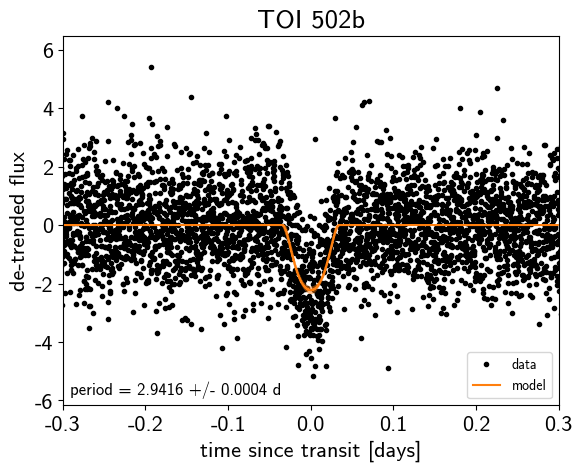

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

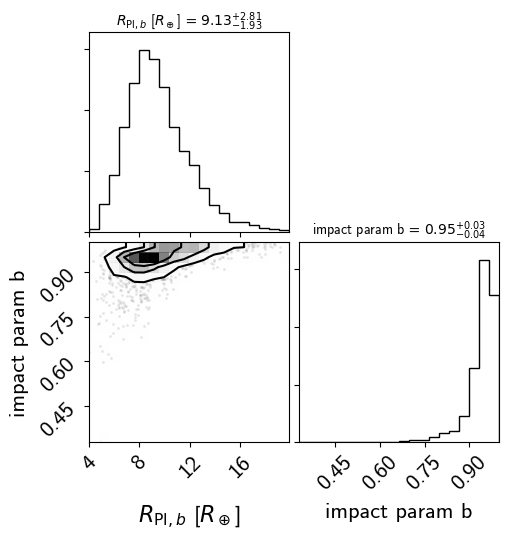

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

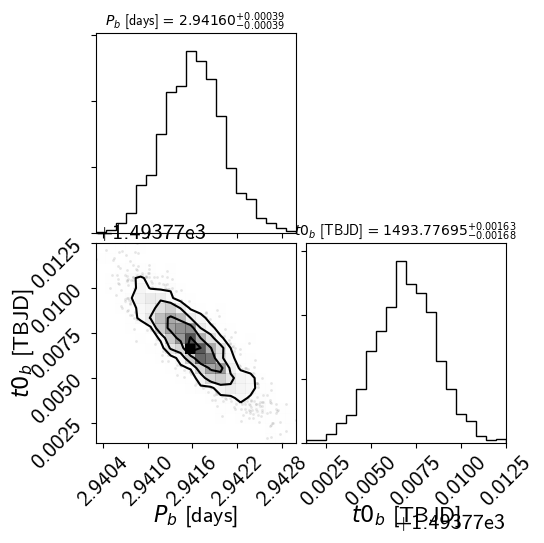

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

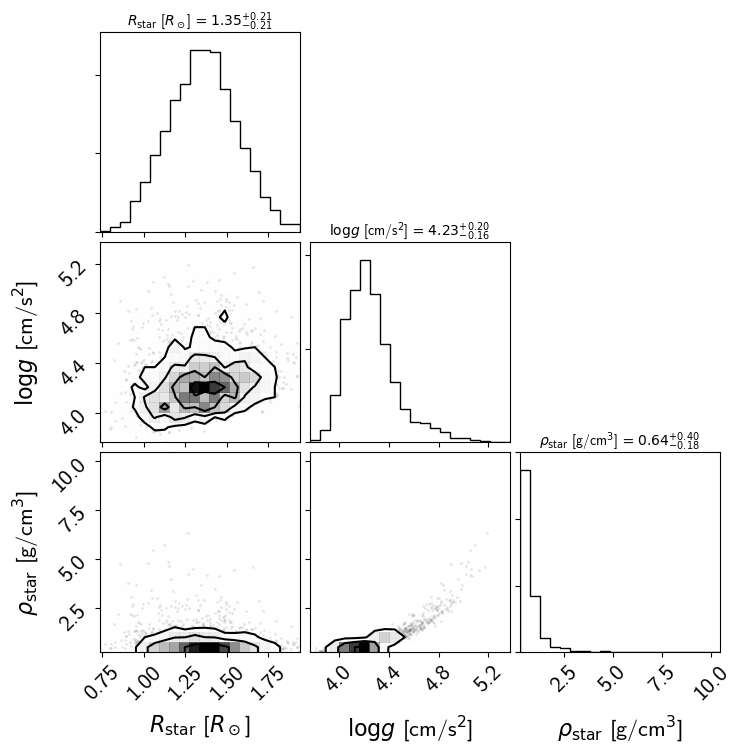

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3